## **Flight Price Prediction Analysis**

#### **1. Business Objective**

Flight ticket prices can change a lot based on many factors like airline, time of booking, travel class and routes. This makes it hard for travelers to know if they are paying a fair price or how to get the best deal. The project aims to study flight booking data from the "Ease My Trip" website for India's major cities. The goal is to understand how different factors affect ticket prices.

This study will help travelers make smarter decisions by showing patterns in prices. It will also help businesses like travel agencies and airlines better understand pricing trends.

The project will answer questions like:

* Do ticket prices differ between airlines?
* How does booking time before departure affect the price?
* Does the time of departure or arrival change ticket costs?
* How do prices vary based on where the flight starts and ends?
* What is the price difference between Economy and Business class tickets?


#### **2. Data Collection**
The project uses data collected over 50 days with over 300,000 flight options. It applies statistical and machine learning methods to predict flight prices based on the factors above. The findings will offer practical insights for travelers and businesses to optimise booking strategies and pricing models.

Dataset source: Flight Price Prediction Dataset from Kaggle [Click here to download](https://www.kaggle.com/datasets/shubhambathwal/flight-price-prediction)


In [1]:
# Connecting to Google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Importing the necessary libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Setting up some parameters for the workbook

pd.set_option('display.max_rows', 500)
pd.options.display.max_columns = None
pd.options.display.float_format = '{:.4f}'.format

%matplotlib inline
matplotlib.rcParams["figure.figsize"] = (25, 5)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.model_selection import GridSearchCV

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import pickle
import time

#### **3. Data Preparation/Preprocessing**

We will start with loading and familiarizing with the dataset so that we can prepare the data for Machine Learning (ML) modelling.

In [5]:
# Loading the dataset

file_path = "/content/drive/MyDrive/Dataset/Flight Price Prediction/Clean_Dataset.csv"
flight = pd.read_csv(file_path)

In [6]:
# Checking the features and no. of records in the dataset

print("The number of records are : ", flight.shape[0])
print("The number of features are : ", flight.shape[1])
print("The list of features is : ", flight.columns.tolist())
flight.head()

The number of records are :  300153
The number of features are :  12
The list of features is :  ['Unnamed: 0', 'airline', 'flight', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class', 'duration', 'days_left', 'price']


,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.1700,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.3300,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.1700,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.2500,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.3300,1,5955


##### Observations:

There are 300,153 records and 12 features. The features are Unnamed: 0, airline, flight, source\_city, departure\_time, stops, arrival\_time, destination\_city, class, duration, days\_left and price.




##### **3.1 Data Cleaning**
We will begin with data cleaning such that we can handle missing values, outliers, rare values and drop the unnecessary features that do not carry useful information.

In [7]:
# Checking for duplicates

print("No. of duplicate records in the dataset : ", flight.duplicated().sum())

No. of duplicate records in the dataset :  0


In [8]:
# Checking the columns' titles and datatypes

flight.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   class             300153 non-null  object 
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 27.5+ MB


##### Observations:
1. There are no duplicate records in the dataset.
2. The dataset uses 27.5 MB of memory and It has 1 float column, 3 integer columns and 8 text columns.


##### **3.1.1 Handling Missing Values**

Identifying the features that have some missing values and imputing them.


In [9]:
# Checking for missing values
missing_stats = []

for col in flight.columns:
    missing_stats.append((col,
                          flight[col].nunique(),
                          flight[col].isnull().sum() / flight.shape[0],
                          flight[col].value_counts(normalize=True,
                                                   dropna=False)
                          .values[0],
                          flight[col].dtype))

stats_flight = pd.DataFrame(missing_stats, columns=['feature', 'unique_values', 'percent_missing', 'percent_biggest_cat', 'type'])
stats_flight

,feature,unique_values,percent_missing,percent_biggest_cat,type
0,Unnamed: 0,300153,0.0000,0.0000,int64
1,airline,6,0.0000,0.4260,object
2,flight,1561,0.0000,0.0108,object
3,source_city,6,0.0000,0.2044,object
4,departure_time,6,0.0000,0.2370,object
5,stops,3,0.0000,0.8358,object
6,arrival_time,6,0.0000,0.3050,object
7,destination_city,6,0.0000,0.1969,object
8,class,2,0.0000,0.6885,object
9,duration,476,0.0000,0.0141,float64


##### Observations:
There are no missing values in any column. The column with the highest category share is `stops` with one category making up 83.58 % of the values. The `airline` column has 6 unique values with the largest category at 42.6% and the `class` column has 2 unique values with the largest at 68.85%.


##### **3.1.2 Dropping Unnecessary Features**

Removing features that do not contribute to the analysis or prediction.


In [10]:
# Dropping unnecessary column
print("Original columns:", flight.columns.tolist())
flight.drop(['Unnamed: 0'], axis=1, inplace=True)
print("Columns after dropping unnecessary features:", flight.columns.tolist())

Original columns: ['Unnamed: 0', 'airline', 'flight', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class', 'duration', 'days_left', 'price']
Columns after dropping unnecessary features: ['airline', 'flight', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class', 'duration', 'days_left', 'price']


##### Observations:

The original dataset had 12 columns,after removing Unnamed: 0, the dataset has 11 columns.


#### **3.2 Exploratory Data Analysis**

After the data cleaning steps, we can now perform EDA on the dataset to discover patterns and relationships that will help in understanding the data better.


##### **3.2.1 Univariate Analysis**

Analyzing each feature individually to gain insights from the data and discover any outliers.

Analyzing the target variable "price"

In [11]:
print(flight["price"].describe())

count   300153.0000
mean     20889.6605
std      22697.7674
min       1105.0000
25%       4783.0000
50%       7425.0000
75%      42521.0000
max     123071.0000
Name: price, dtype: float64


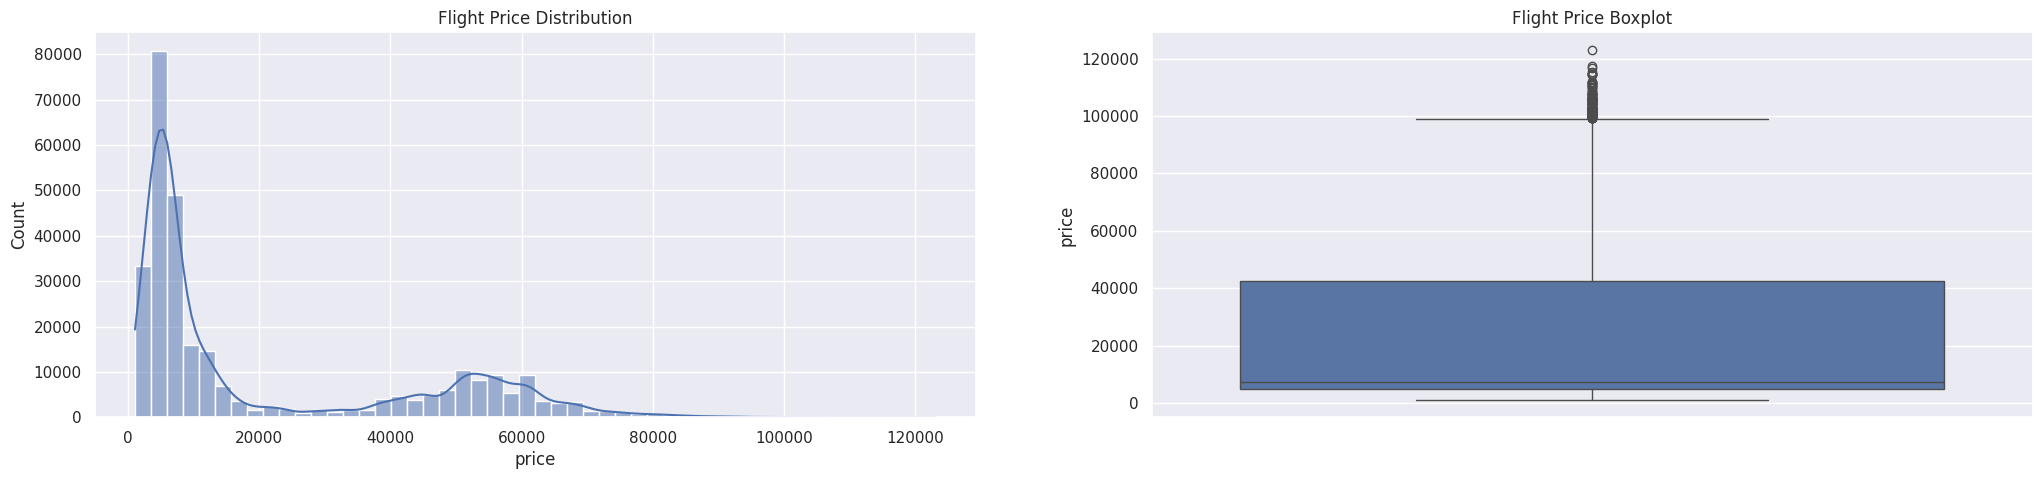

In [12]:
sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 2, figsize=(25, 5), sharey=False)
sns.histplot(flight["price"], bins=50, kde=True, ax=axes[0])
axes[0].set_title('Flight Price Distribution')
sns.boxplot(y=flight["price"], ax=axes[1])
axes[1].set_title('Flight Price Boxplot')
plt.show()

##### Observations:

The average flight price is 20,889.66 with prices ranging from 1,105 to 123,071. Most flights cost between 4,783 and 42,521, and the distribution is right-skewed, showing more low-priced flights than high-priced ones. Several outliers exist above 120,000 which may represent premium or last-minute bookings.


In [13]:
# Checking the feature "airline"
print("The no. of unique Airlines is : ", flight["airline"].nunique())
print("The count of each Airline are : \n", flight["airline"].value_counts())

The no. of unique Airlines is :  6
The count of each Airline are : 
 airline
Vistara      127859
Air_India     80892
Indigo        43120
GO_FIRST      23173
AirAsia       16098
SpiceJet       9011
Name: count, dtype: int64


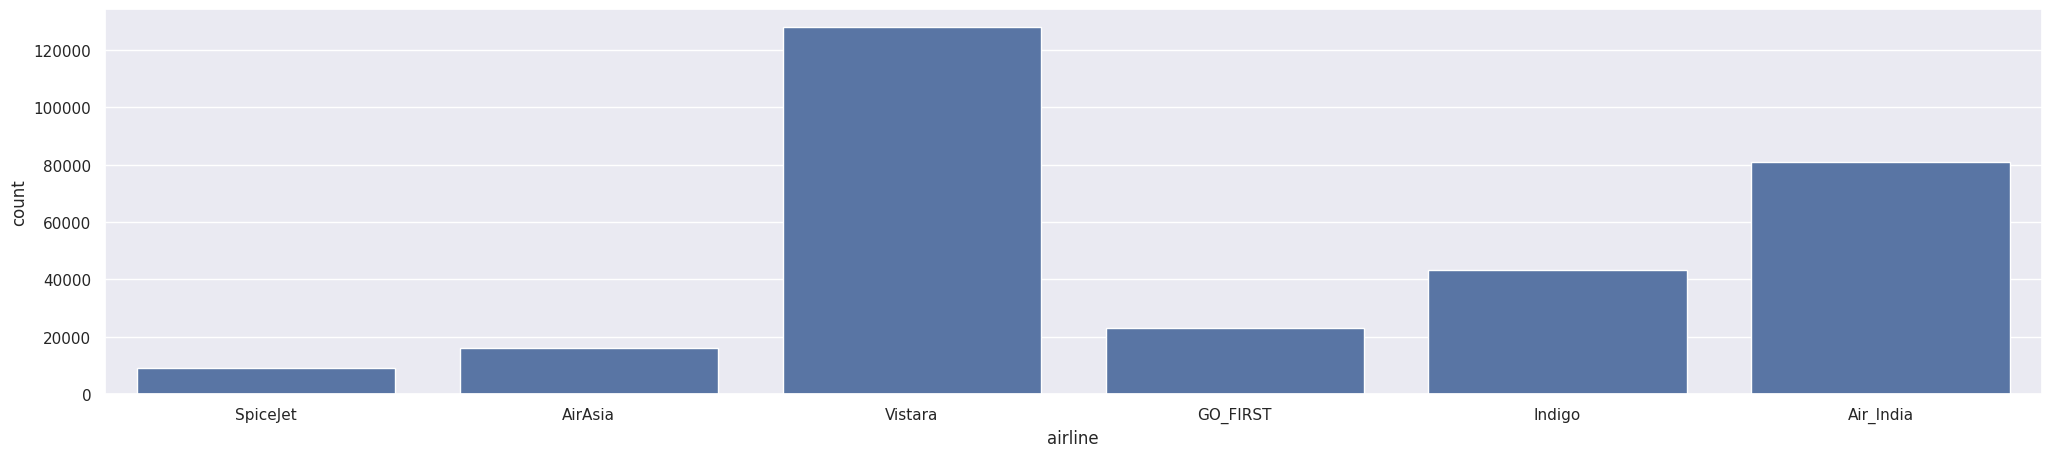

In [14]:
sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5))
sns.countplot(x="airline", data=flight, ax=axes)
plt.xticks(rotation=0)
plt.show()

##### Observations:

Vistara has the highest count at 127,859, followed by Air India with 80,892, Indigo with 43,120, GO_FIRST with 23,173, AirAsia with 16,098 and SpiceJet with 9,011.



In [15]:
# Checking the feature "source_city"
print("The no. of unique Source Cities is : ", flight["source_city"].nunique())
print("The count of each Source City are : \n", flight["source_city"].value_counts())

The no. of unique Source Cities is :  6
The count of each Source City are : 
 source_city
Delhi        61343
Mumbai       60896
Bangalore    52061
Kolkata      46347
Hyderabad    40806
Chennai      38700
Name: count, dtype: int64


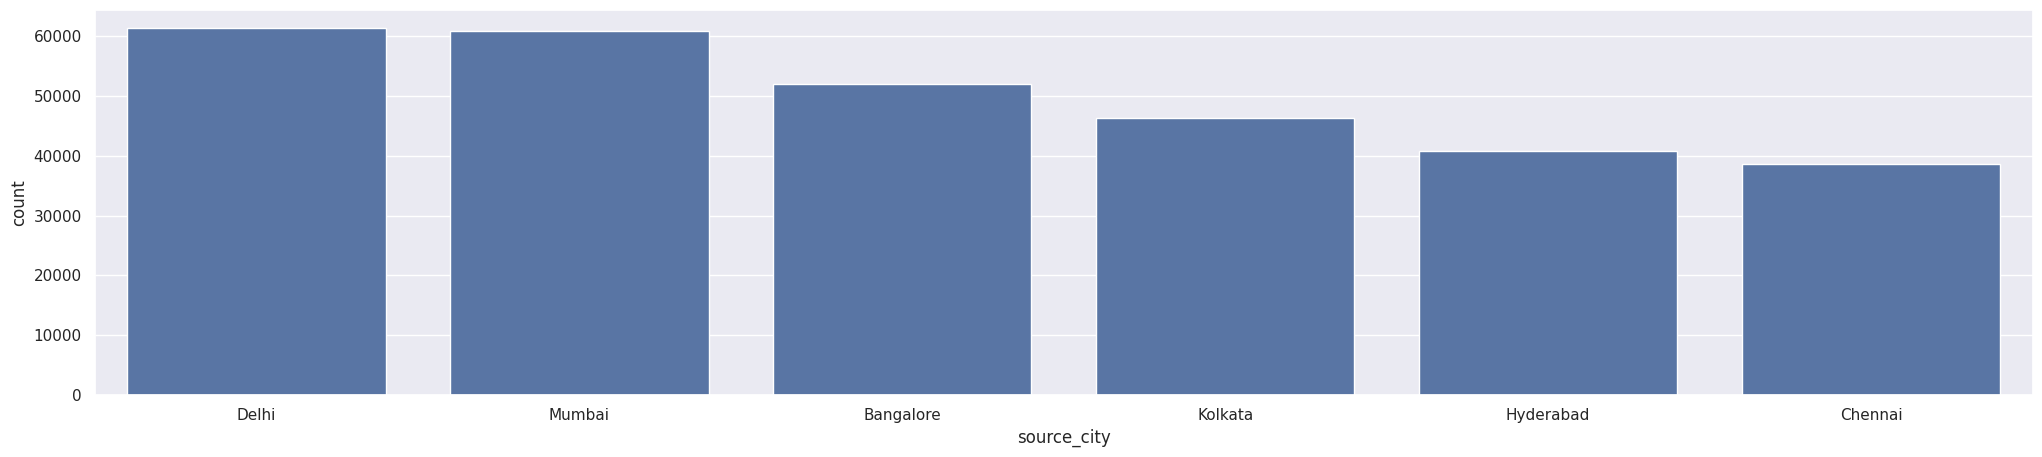

In [16]:
sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5))
sns.countplot(x="source_city", data=flight, ax=axes)
plt.xticks(rotation=0)
plt.show()

##### Observations:

It's more obvious that Delhi would have 61k+ taking the top since New Delhi city (Capital City of India) is a district of Delhi and Mumbai city having 60k+ records,  Bangalore with 52k+, Kolkata with 46k+, Hyderabad with 40k+ and Chennai with 38k+

In [17]:
# Checking the feature "destination_city"

print("The no. of unique Destination Cities is : ", flight["destination_city"].nunique())
print("The count of each Destination City are : \n", flight["destination_city"].value_counts())

The no. of unique Destination Cities is :  6
The count of each Destination City are : 
 destination_city
Mumbai       59097
Delhi        57360
Bangalore    51068
Kolkata      49534
Hyderabad    42726
Chennai      40368
Name: count, dtype: int64


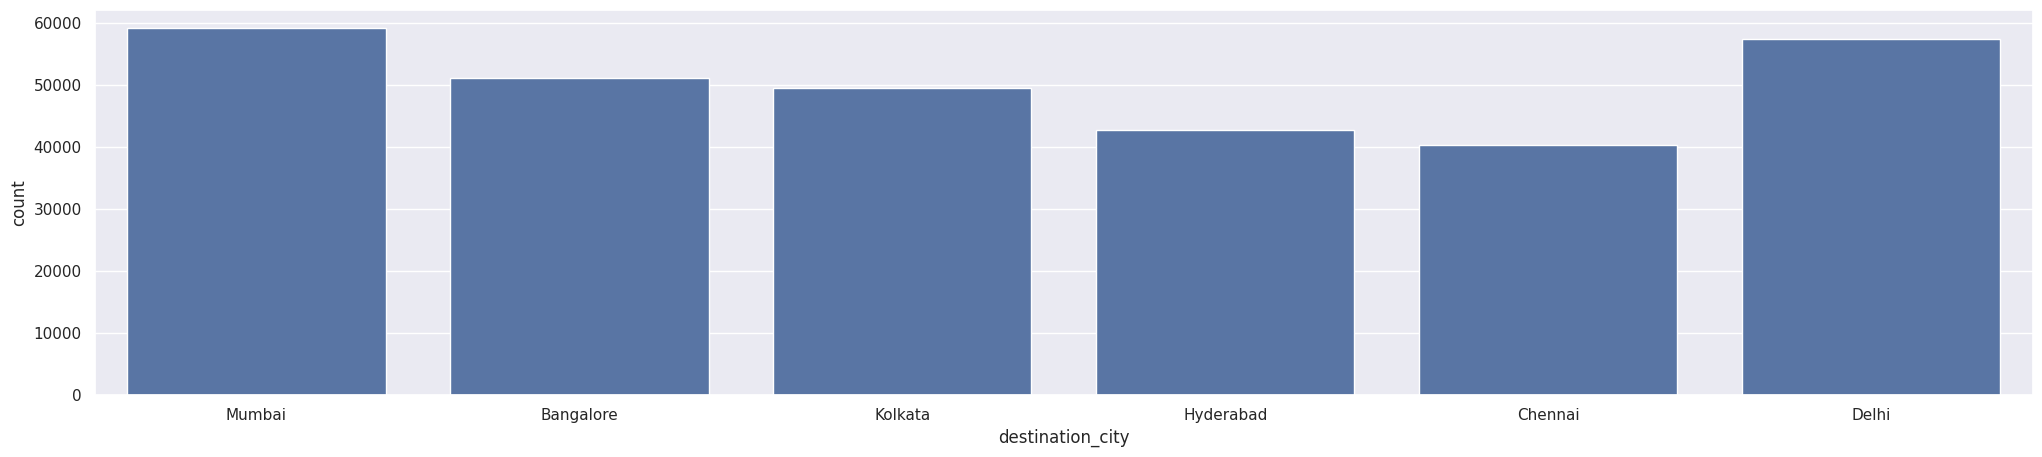

In [18]:
sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5))
sns.countplot(x="destination_city", data=flight, ax=axes)
plt.xticks(rotation=0)
plt.show()

##### Observations:

On other hand, Mumbai city leads with 59k+ destination flight, There are several contributing factors since it on located in the coastal region. Second by Delhi with 57k+ and Bangalore with 51k+ visits, Kolkata with 49k+, Hyderabad with 42k+ and Chennai with 40k+.

In [19]:
# Checking the feature "departure_time"

print("The no. of unique Departure Times is : ", flight["departure_time"].nunique())
print("The count of each Departure Time are : \n", flight["departure_time"].value_counts())

The no. of unique Departure Times is :  6
The count of each Departure Time are : 
 departure_time
Morning          71146
Early_Morning    66790
Evening          65102
Night            48015
Afternoon        47794
Late_Night        1306
Name: count, dtype: int64


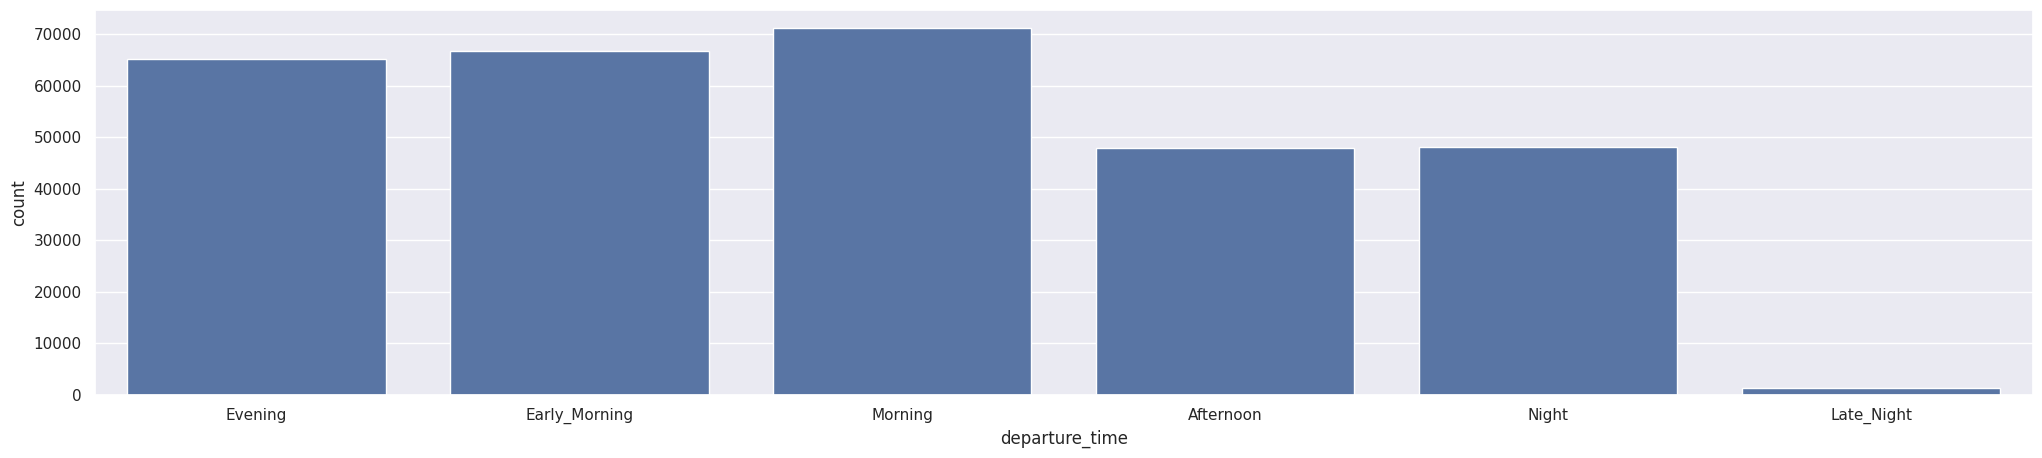

In [20]:
sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5))
sns.countplot(x="departure_time", data=flight, ax=axes)
plt.xticks(rotation=0)
plt.show()

##### Observations:
For departure time, most travels occur in the morning with 71,146 records and early morning with 66,790 while late night has the fewest at 1,306.

In [21]:
# Checking the feature "arrival_time"

print("The no. of unique Arrival Times is : ", flight["arrival_time"].nunique())
print("The count of each Arrival Time are : \n", flight["arrival_time"].value_counts())

The no. of unique Arrival Times is :  6
The count of each Arrival Time are : 
 arrival_time
Night            91538
Evening          78323
Morning          62735
Afternoon        38139
Early_Morning    15417
Late_Night       14001
Name: count, dtype: int64


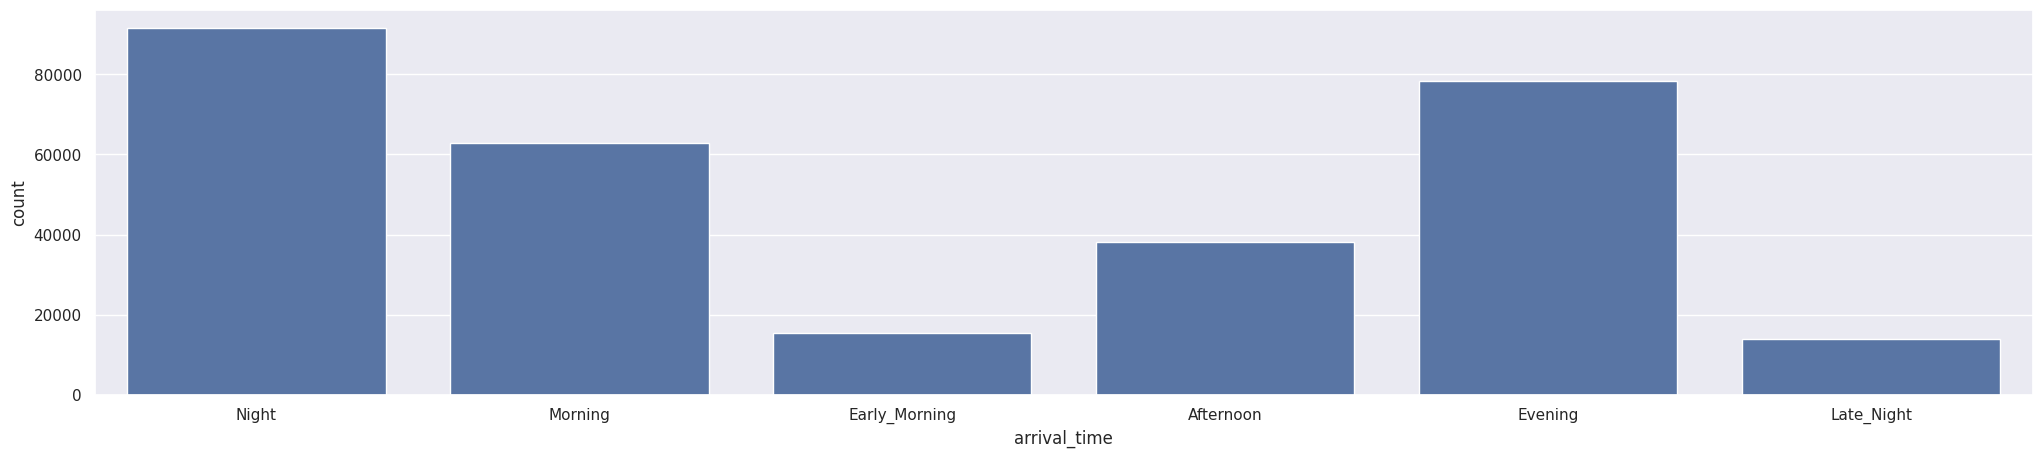

In [22]:
sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5))
sns.countplot(x="arrival_time", data=flight, ax=axes)
plt.xticks(rotation=0)
plt.show()

##### Observations:
On other hands the arrival time is majorly seems from evening hours to at night,  Night has 91538 records and Evening with 78323 records

In [23]:
# Checking the feature "stops"

print("The no. of unique Stop categories is : ", flight["stops"].nunique())
print("The count of each Stop category are : \n", flight["stops"].value_counts())

The no. of unique Stop categories is :  3
The count of each Stop category are : 
 stops
one            250863
zero            36004
two_or_more     13286
Name: count, dtype: int64


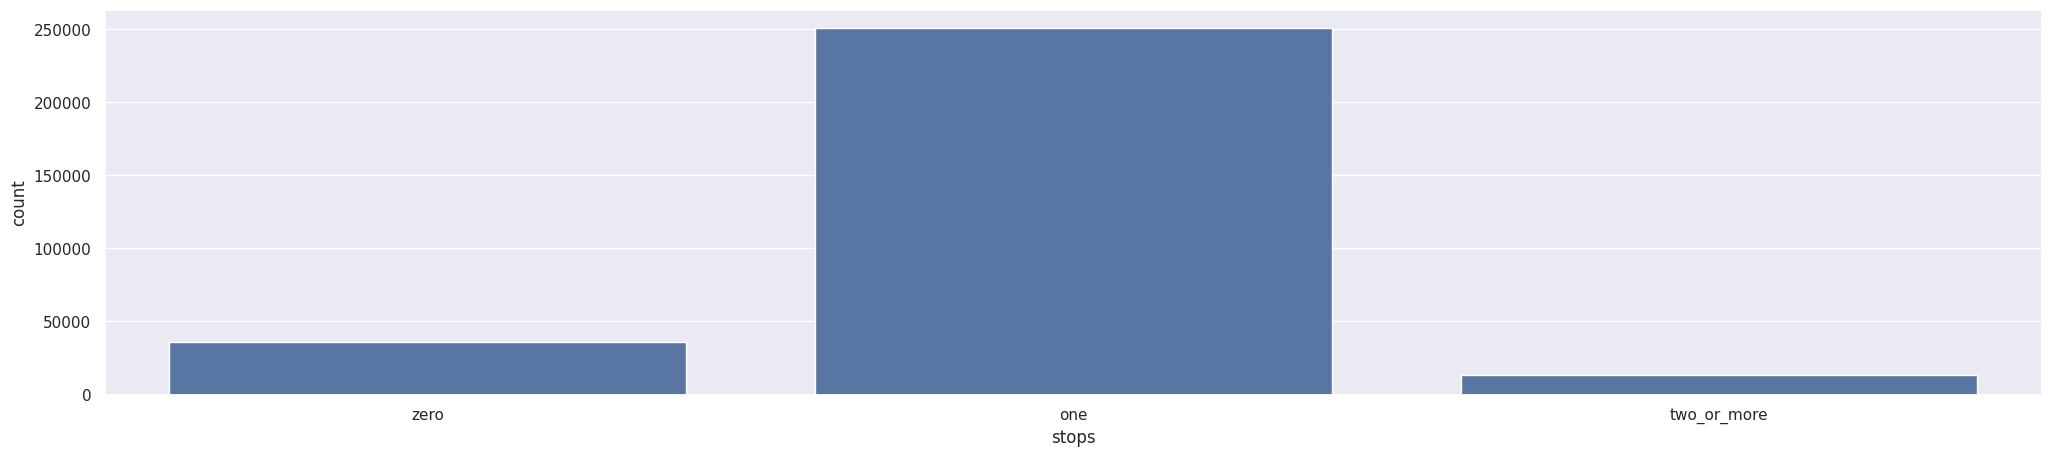

In [24]:
sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5))
sns.countplot(x="stops", data=flight, ax=axes)
plt.show()

##### Observations:
One stop has the most records of 250863 records, followed by zero stops with 36,004 and two or more stops with 13,286.


In [25]:
# Checking the feature "class"

print("The no. of unique Classes is : ", flight["class"].nunique())
print("The count of each Class are : \n", flight["class"].value_counts())

The no. of unique Classes is :  2
The count of each Class are : 
 class
Economy     206666
Business     93487
Name: count, dtype: int64


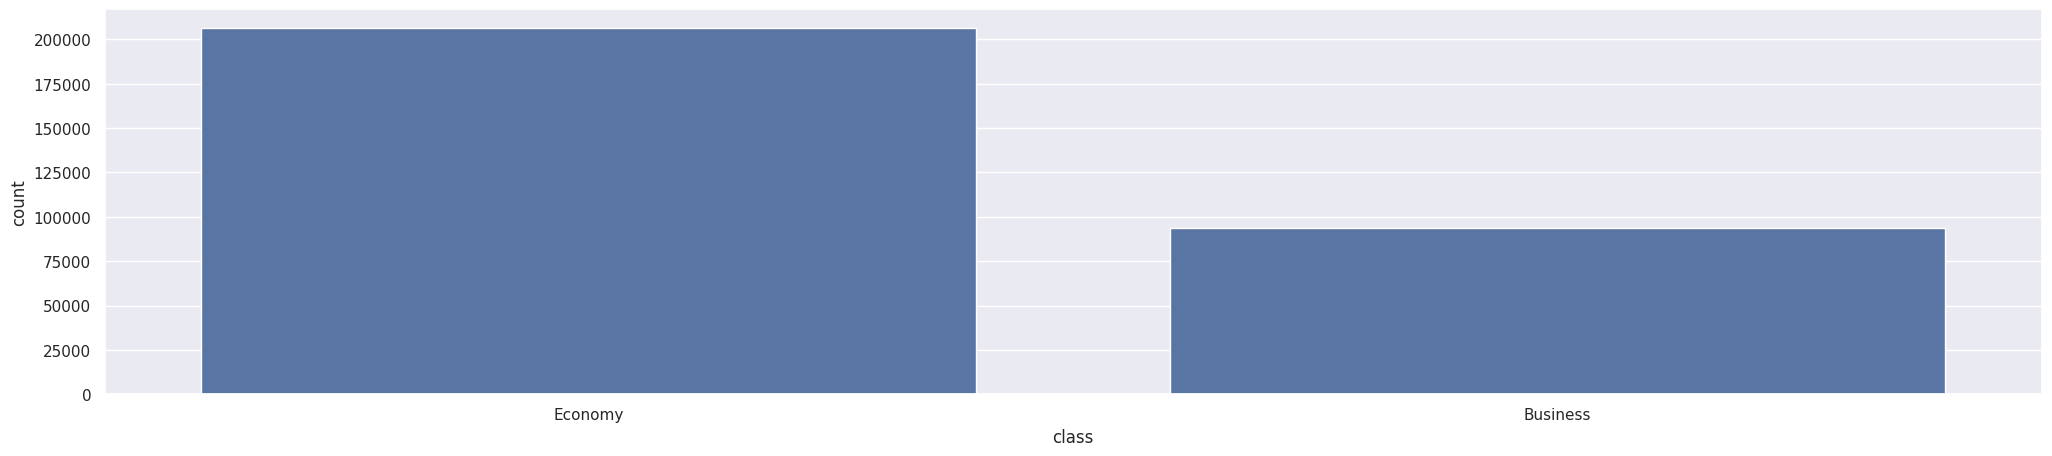

In [26]:
sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5))
sns.countplot(x="class", data=flight, ax=axes)
plt.show()

##### Observations:
Majority travels on Economy class which has 206666 records

In [27]:
# Analyzing the "duration" feature
print("The basic statistics for Duration are:")
print(flight["duration"].describe())

The basic statistics for Duration are:
count   300153.0000
mean        12.2210
std          7.1920
min          0.8300
25%          6.8300
50%         11.2500
75%         16.1700
max         49.8300
Name: duration, dtype: float64


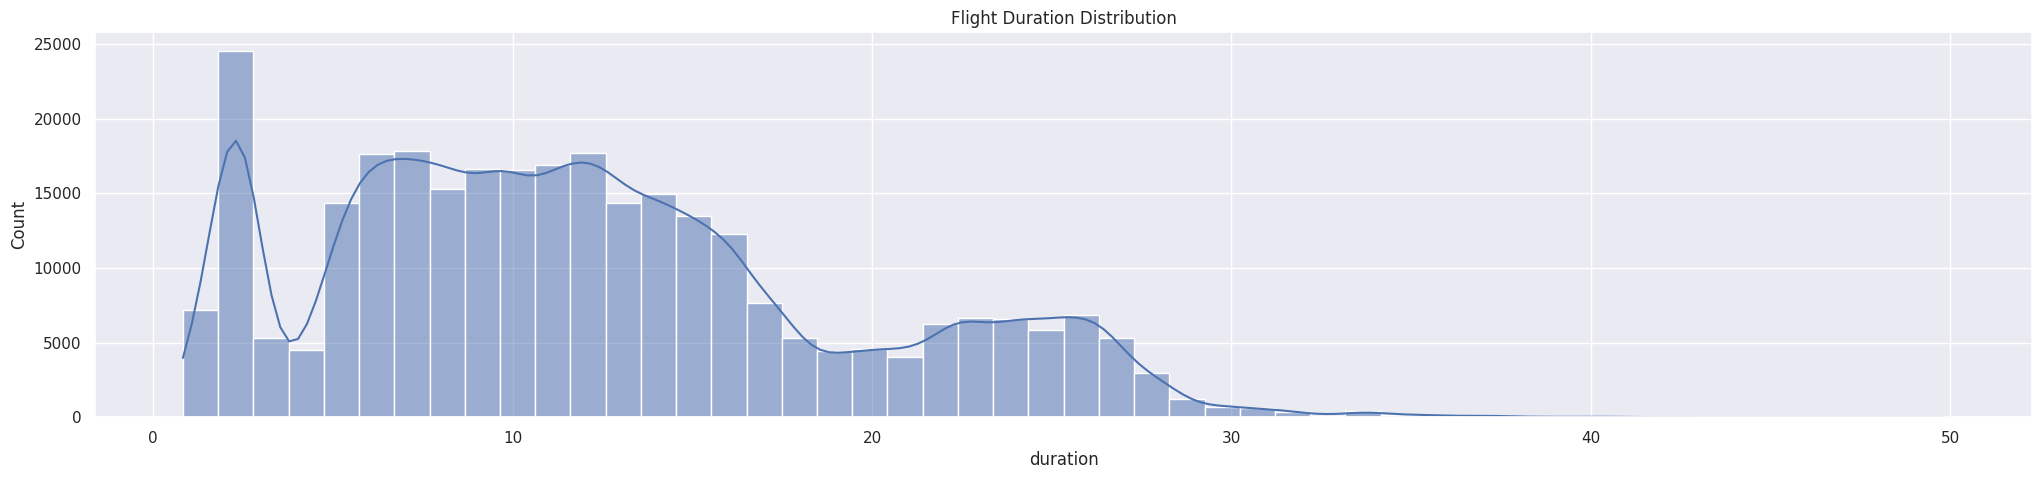

In [28]:
sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5))
sns.histplot(flight["duration"], bins=50, kde=True, ax=axes)
axes.set_title('Flight Duration Distribution')
plt.show()

##### Observations:

On average, a flight takes about 12.2 hours, the shortest flight in the data lasted only 0.83 hours (which is around 50 minutes) and the longest flight lasted about 49.8 hours (a little over 2 days) which could be cargo flights.

Most flights last between 7 to 16 hours, with some very short and some very long flights.

In [29]:
# Checking the feature "flight"
print("The no. of unique Flights is : ", flight["flight"].nunique())
print("The count of each Flight are : \n", flight["flight"].value_counts().head(10))

The no. of unique Flights is :  1561
The count of each Flight are : 
 flight
UK-706    3235
UK-772    2741
UK-720    2650
UK-836    2542
UK-822    2468
UK-828    2440
UK-874    2423
UK-832    2404
UK-826    2335
UK-860    2329
Name: count, dtype: int64


In [30]:
# Get the top 10 flights by frequency
top_flights = flight["flight"].value_counts().head(10).index.tolist()
# Filter the dataset for these top flights
top_flights_data = flight[flight["flight"].isin(top_flights)]
# Analyze the top flights (e.g., average price, duration, airline, etc.)
flight_analysis = top_flights_data.groupby("flight").agg({
    "price": ["mean", "count"],
    "duration": "mean",
    "airline": lambda x: x.mode()[0],  # Most common airline for this flight
    "source_city": lambda x: x.mode()[0],  # Most common source city
    "destination_city": lambda x: x.mode()[0]  # Most common destination city
}).round(2)

In [31]:
flight_analysis.columns = ["avg_price", "frequency", "avg_duration", "most_common_airline", "most_common_source", "most_common_destination"]
flight_analysis = flight_analysis.sort_values("frequency", ascending=False)

print("\nTop 10 Flights Analysis:")
print(flight_analysis)


Top 10 Flights Analysis:
        avg_price  frequency  avg_duration most_common_airline  \
flight                                                           
UK-706 32726.9100       3235       12.6600             Vistara   
UK-772 35466.2200       2741       13.8500             Vistara   
UK-720 32144.2100       2650       12.6800             Vistara   
UK-836 33194.1000       2542       11.0700             Vistara   
UK-822 27586.7500       2468       13.9000             Vistara   
UK-828 28283.4700       2440       12.9100             Vistara   
UK-874 26982.5900       2423       13.8600             Vistara   
UK-832 31499.7200       2404       13.5300             Vistara   
UK-826 26276.5300       2335       13.6900             Vistara   
UK-860 31690.8700       2329       13.0900             Vistara   

       most_common_source most_common_destination  
flight                                             
UK-706            Kolkata                  Mumbai  
UK-772            Kolkata

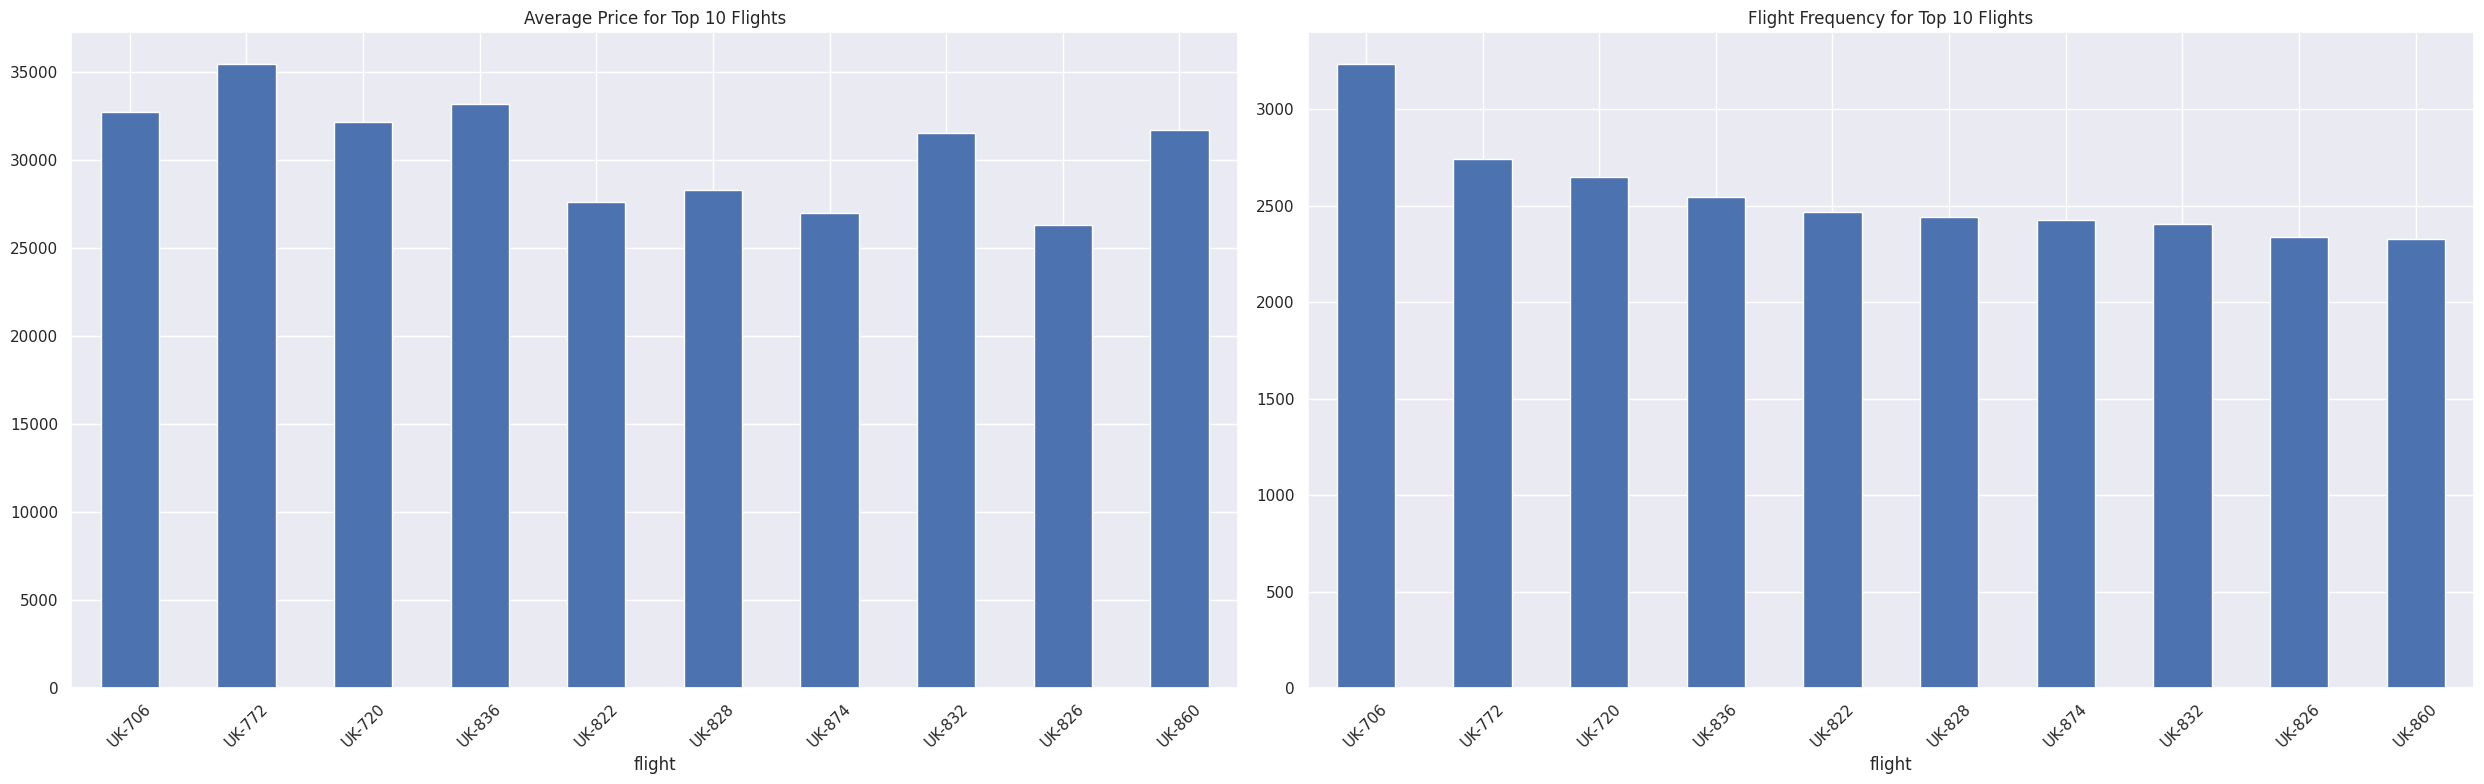

In [32]:
# Visualizing the top flights
sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 2, figsize=(25, 8))
flight_analysis["avg_price"].plot(kind='bar', ax=axes[0])
axes[0].set_title('Average Price for Top 10 Flights')
axes[0].tick_params(axis='x', rotation=45)
flight_analysis["frequency"].plot(kind='bar', ax=axes[1])
axes[1].set_title('Flight Frequency for Top 10 Flights')
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

##### Observations
1. Top flights cost ₹26,000 to 35,000 indicating premium routes with heavy business demand. Flight UK-772 (Kolkata-Delhi) is the priciest at ₹35,466 linked to high demand and long duration.
2. The most frequent flight is UK-706 with (3,235 trips) it has moderate prices, this showing competition lowers fares. Less frequent flights like UK-772 (2,741 trips) charge higher prices due to limited options.
3. Vistara operates all top 10 flights suggesting market dominance on key business routes which may keep prices high.
4. Flights longer than 13 hours cost 10 to 15% more than shorter routes with similar frequencies. Kolkata routes are pricier due to weaker competition. Chennai-Delhi flights have lower prices likely because of more airlines.
5. Travelers should choose Chennai-Delhi or Hyderabad-Delhi routes for lower fares without losing frequency. Competitors should target Kolkata routes to challenge Vistara’s hold.


#### **3.2.2 Bi-variate Analysis**

Analyzing multiple features together to discover relations, correlations and patterns.

##### **3.2.2.1 Analyzing Price by Airline**


In [33]:
# Statistical summary by airline
airline_price_stats = flight.groupby("airline")["price"].agg(['mean', 'median', 'std', 'min', 'max']).round(2)
print("Price statistics by Airline:")
print(airline_price_stats)

Price statistics by Airline:
                mean     median        std   min     max
airline                                                 
AirAsia    4091.0700  3276.0000  2824.0600  1105   31917
Air_India 23507.0200 11520.0000 20905.1200  1526   90970
GO_FIRST   5652.0100  5336.0000  2513.8700  1105   32803
Indigo     5324.2200  4453.0000  3268.8900  1105   31952
SpiceJet   6179.2800  5654.0000  2999.6300  1106   34158
Vistara   30396.5400 15543.0000 25637.1600  1714  123071


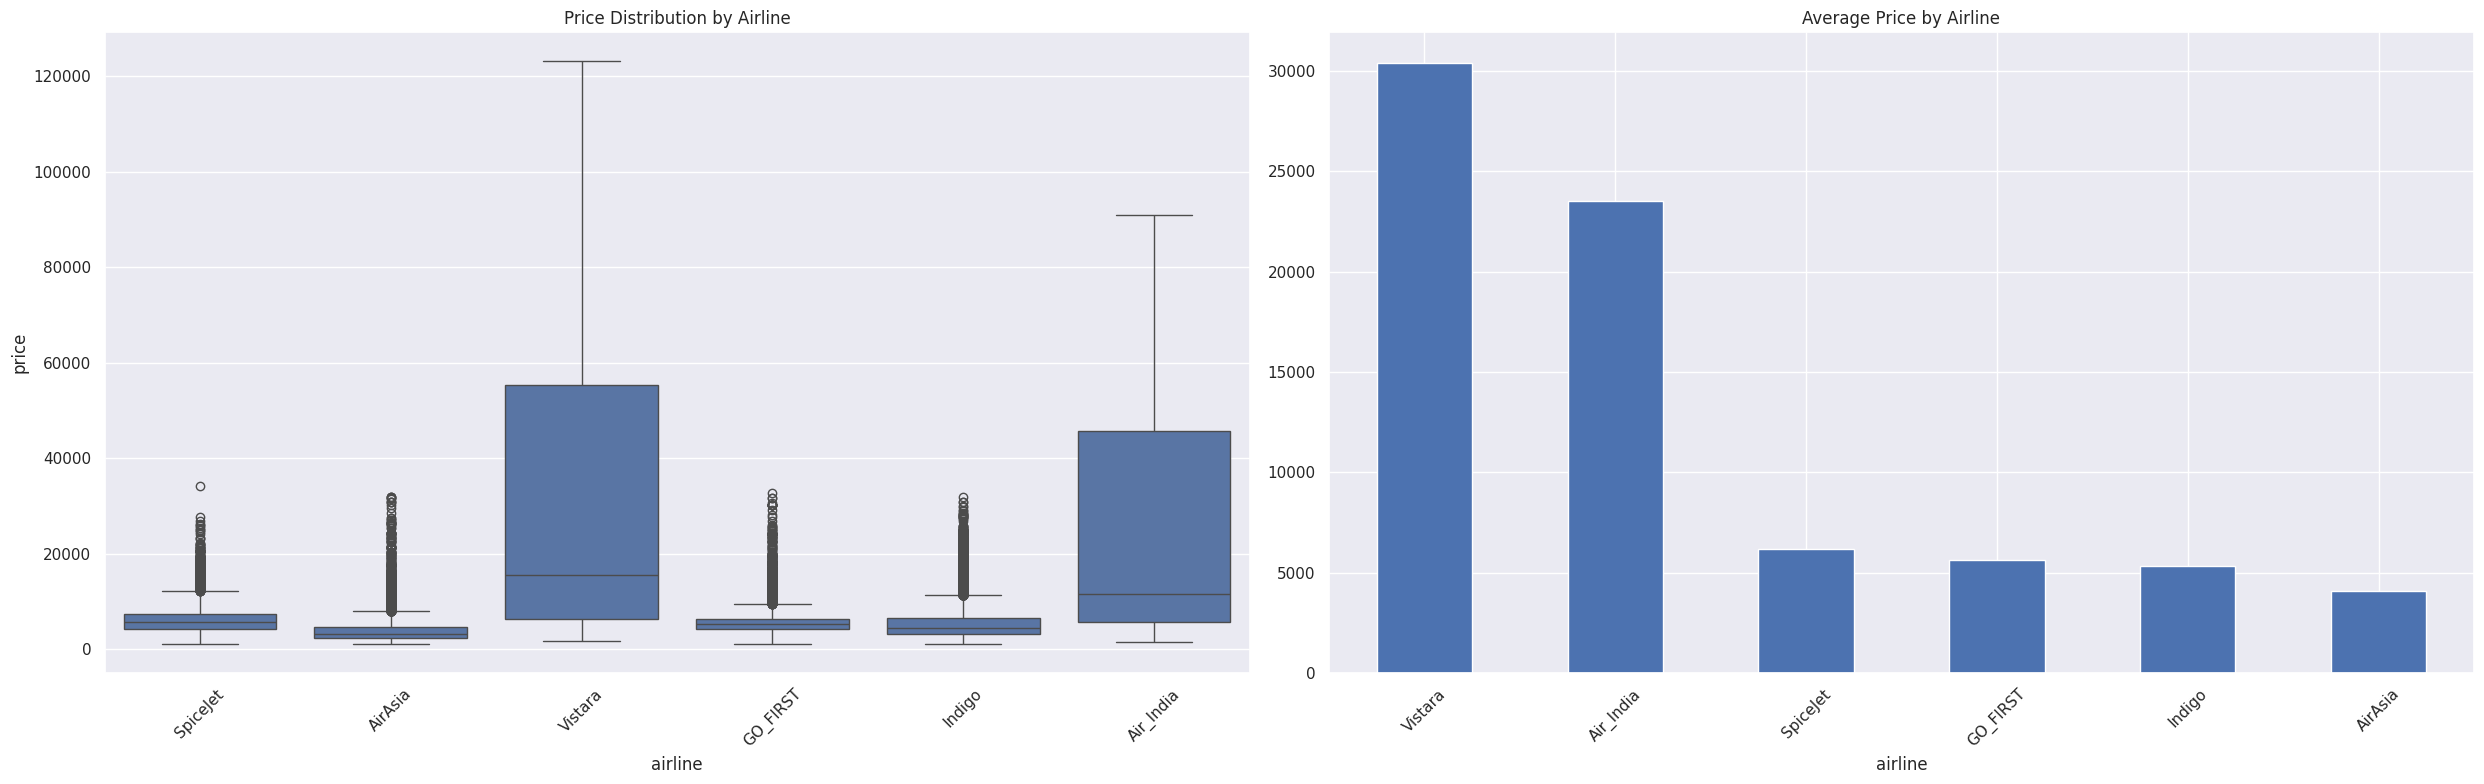

In [34]:
# Price distribution by airline
sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 2, figsize=(25, 8))
sns.boxplot(x="airline", y="price", data=flight, ax=axes[0])
axes[0].set_title('Price Distribution by Airline')
axes[0].tick_params(axis='x', rotation=45)
flight.groupby("airline")["price"].mean().sort_values(ascending=False).plot(kind='bar', ax=axes[1])
axes[1].set_title('Average Price by Airline')
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

##### Observations:
If you want cheaper flights, go for AirAsia, Indigo or GO_FIRST. If you're flying with Vistara or Air India  be prepared to pay much more but you may get more comfort or long-distance options. Vistara has the most expensive tickets overall both in average and in maximum price.

**2. Analyzing Price by Class**

In [35]:
# Statistical summary by class
class_price_stats = flight.groupby("class")["price"].agg(['mean', 'median', 'std', 'count']).round(2)
print("Price statistics by Class:")
print(class_price_stats)

Price statistics by Class:
               mean     median        std   count
class                                            
Business 52540.0800 53164.0000 12969.3100   93487
Economy   6572.3400  5772.0000  3743.5200  206666


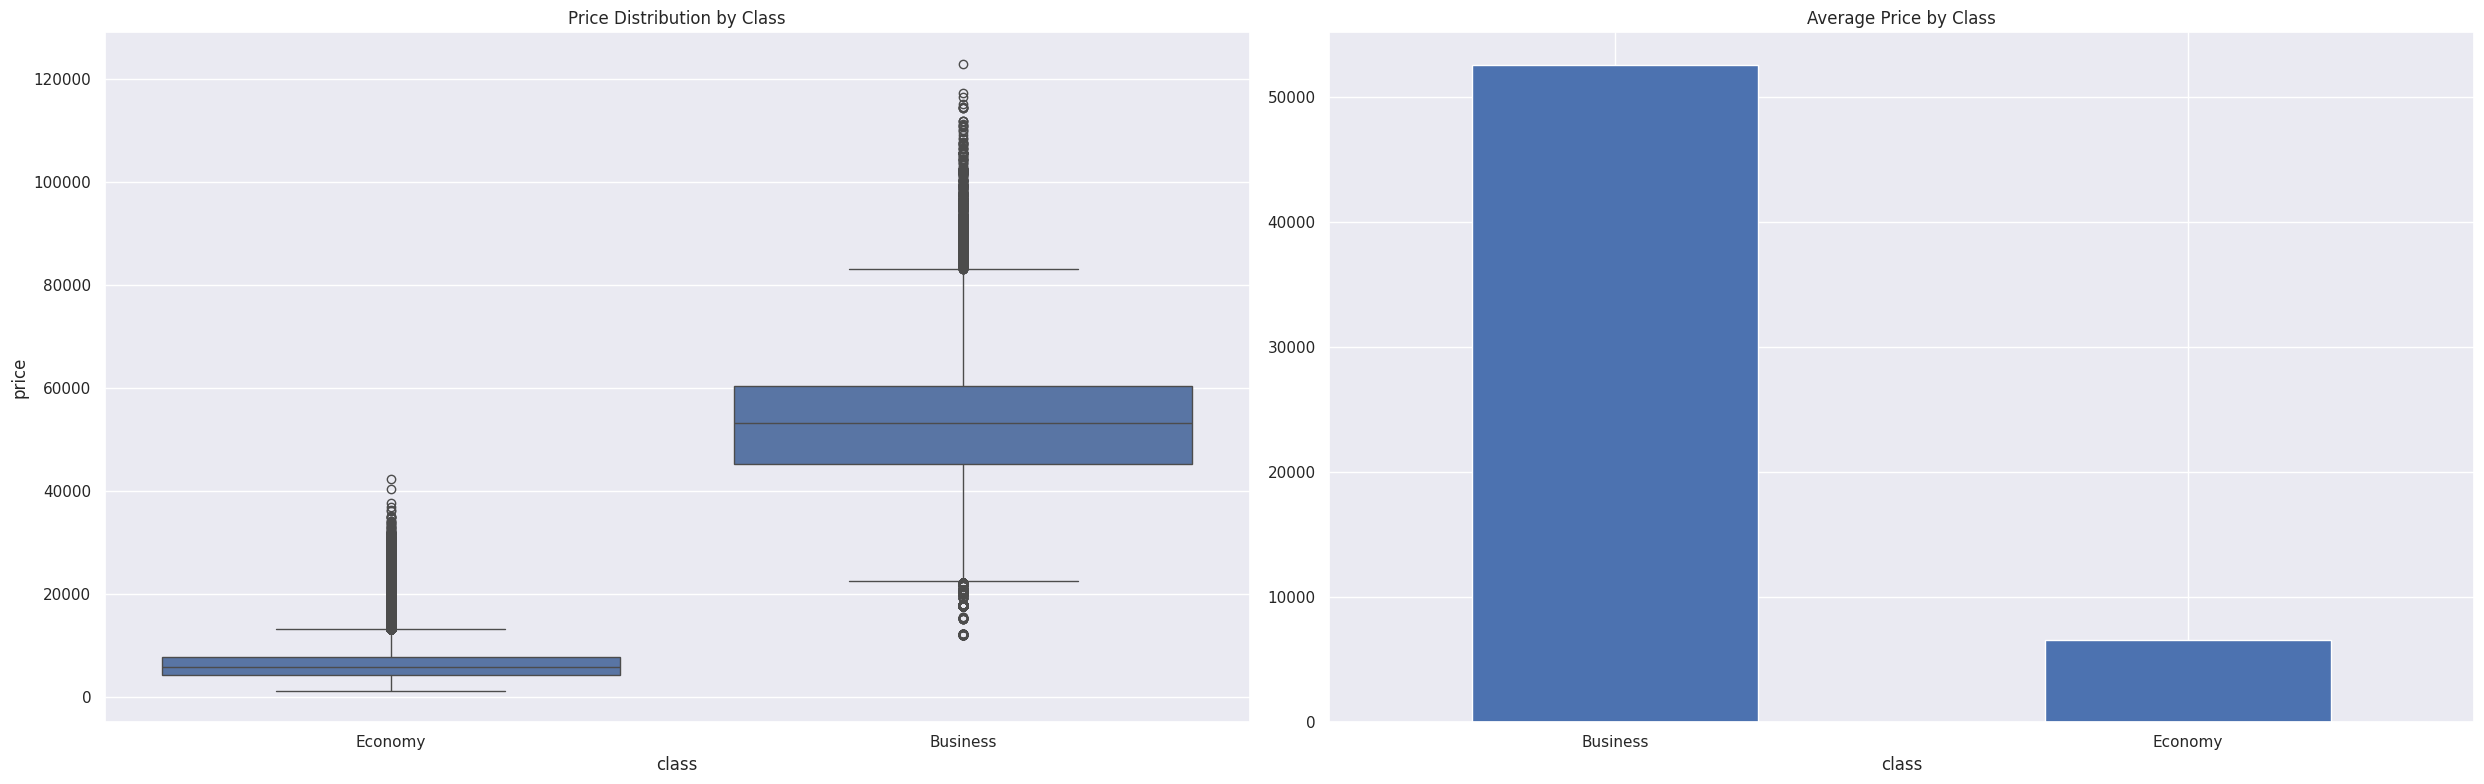

In [36]:
# Price distribution by class
sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 2, figsize=(25, 8))
sns.boxplot(x="class", y="price", data=flight, ax=axes[0])
axes[0].set_title('Price Distribution by Class')
flight.groupby("class")["price"].mean().plot(kind='bar', ax=axes[1])
axes[1].set_title('Average Price by Class')
axes[1].tick_params(axis='x', rotation=0)
plt.tight_layout()
plt.show()

##### Observations:
Business class is about 8 to 9 times more expensive than Economy class on average.

If you're looking for comfort and premium service, you'll pay a lot more in Business class , But for affordable travel, Economy is the better option  it’s much cheaper for most travelers.

**3. Analyzing Price by Number of Stops**

In [37]:
# Statistical summary by stops
stops_price_stats = flight.groupby("stops")["price"].agg(['mean', 'median', 'std', 'count']).round(2)
print("Price statistics by Number of Stops:")
print(stops_price_stats)

Price statistics by Number of Stops:
                  mean    median        std   count
stops                                              
one         22900.9900 7959.0000 23626.0700  250863
two_or_more 14113.4500 8307.0000 17664.3300   13286
zero         9375.9400 4499.0000 10623.0100   36004


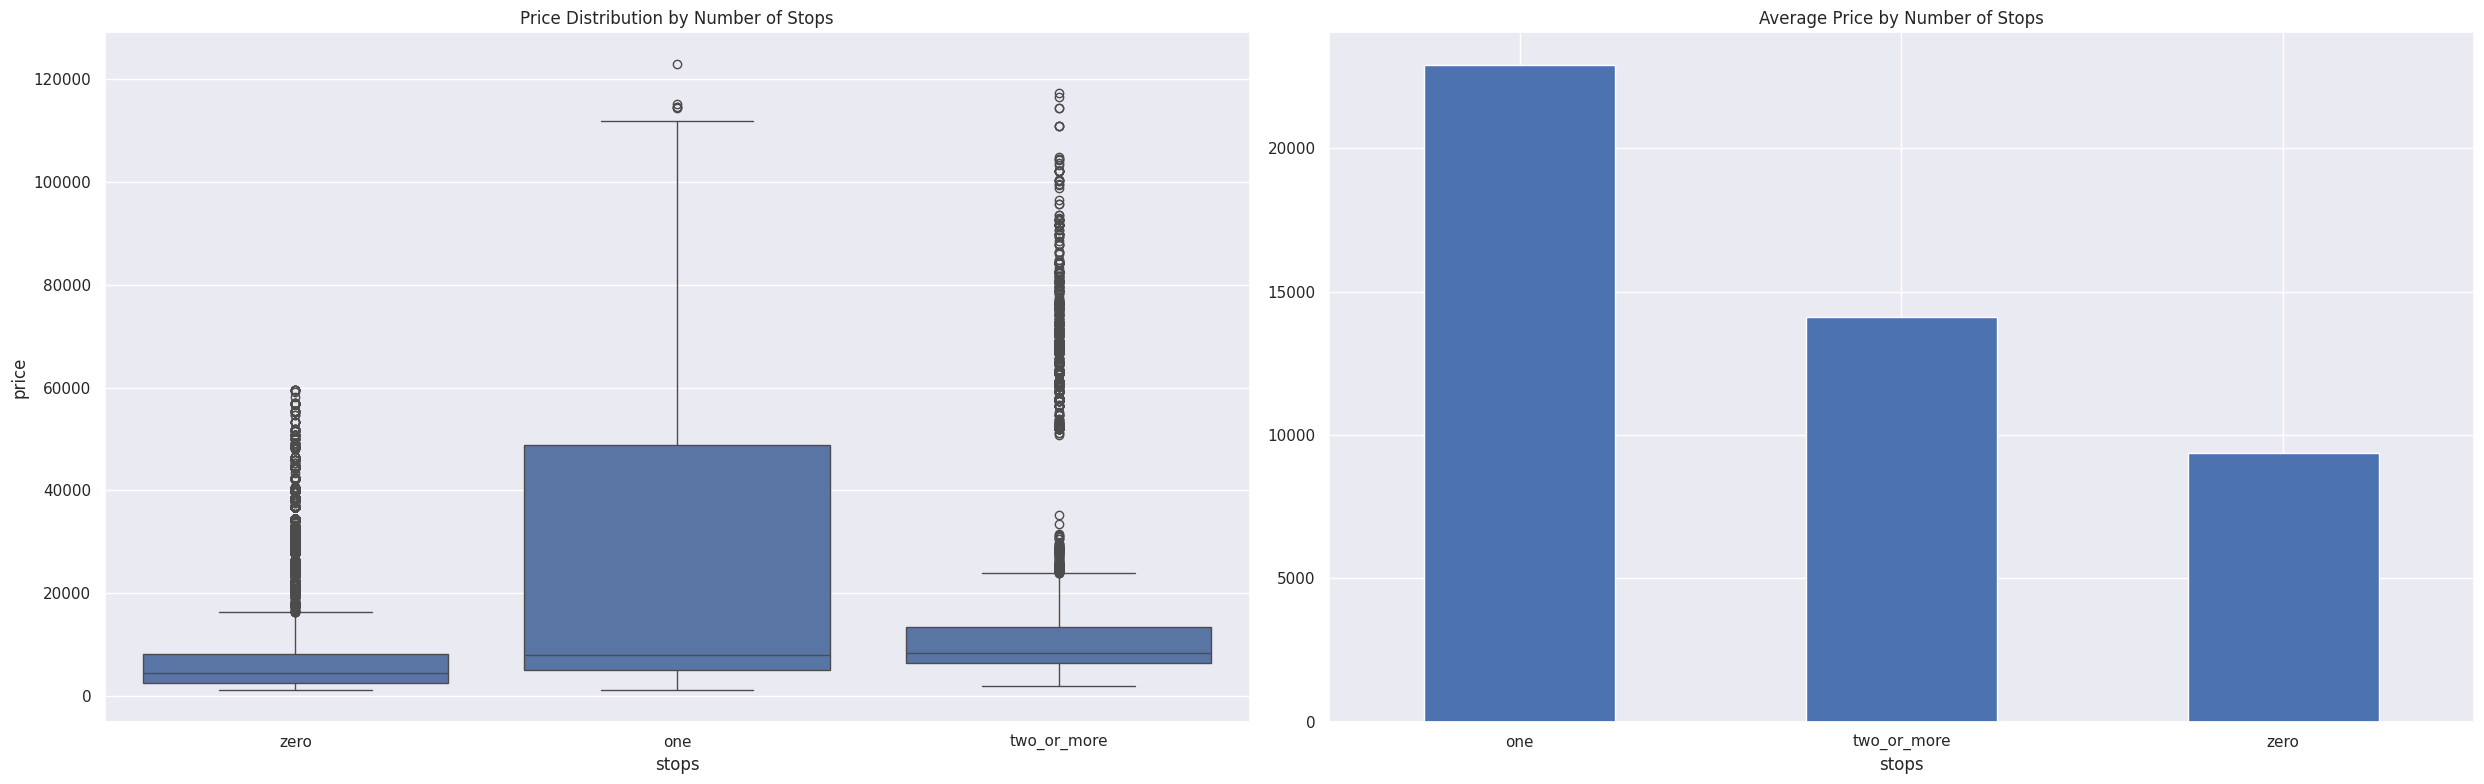

In [38]:
# Price distribution by stops
sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 2, figsize=(25, 8))
sns.boxplot(x="stops", y="price", data=flight, ax=axes[0])
axes[0].set_title('Price Distribution by Number of Stops')
flight.groupby("stops")["price"].mean().plot(kind='bar', ax=axes[1])
axes[1].set_title('Average Price by Number of Stops')
axes[1].tick_params(axis='x', rotation=0)
plt.tight_layout()
plt.show()

##### Observations:
Direct flights (non-stop) are usually the cheapest and most consistent in price. Flights with one stop are often the most expensive  possibly due to longer routes or premium services. Flights with two or more stops are cheaper than one-stop but still cost more than direct flights.

So, if you're on a budget and prefer less travel time, non-stop flights are your best bet.

**4. Analyzing Price by Route (Source and Destination)**

In [39]:
# Creating route combinations for analysis
flight['route'] = flight['source_city'] + ' -> ' + flight['destination_city']

In [40]:
# Top routes by frequency and average price
route_analysis = flight.groupby('route').agg({
    'price': ['mean', 'count'],
    'duration': 'mean'
}).round(2)

In [41]:
route_analysis.columns = ['avg_price', 'frequency', 'avg_duration']
route_analysis = route_analysis.sort_values('frequency', ascending=False)
print("Top 10 routes by frequency:")
print(route_analysis.head(10))

Top 10 routes by frequency:
                     avg_price  frequency  avg_duration
route                                                  
Delhi -> Mumbai     19355.8300      15289       10.3700
Mumbai -> Delhi     18725.3200      14809        9.8200
Delhi -> Bangalore  17880.2200      14012       10.3500
Bangalore -> Delhi  17723.3100      13756        9.7800
Bangalore -> Mumbai 23128.6200      12939       10.9100
Mumbai -> Bangalore 23147.8700      12885       11.6100
Mumbai -> Kolkata   22379.1500      12602       12.8400
Delhi -> Kolkata    20566.4100      11934       12.7400
Kolkata -> Mumbai   22078.8800      11467       12.9900
Delhi -> Chennai    19369.8800      10780       12.4300


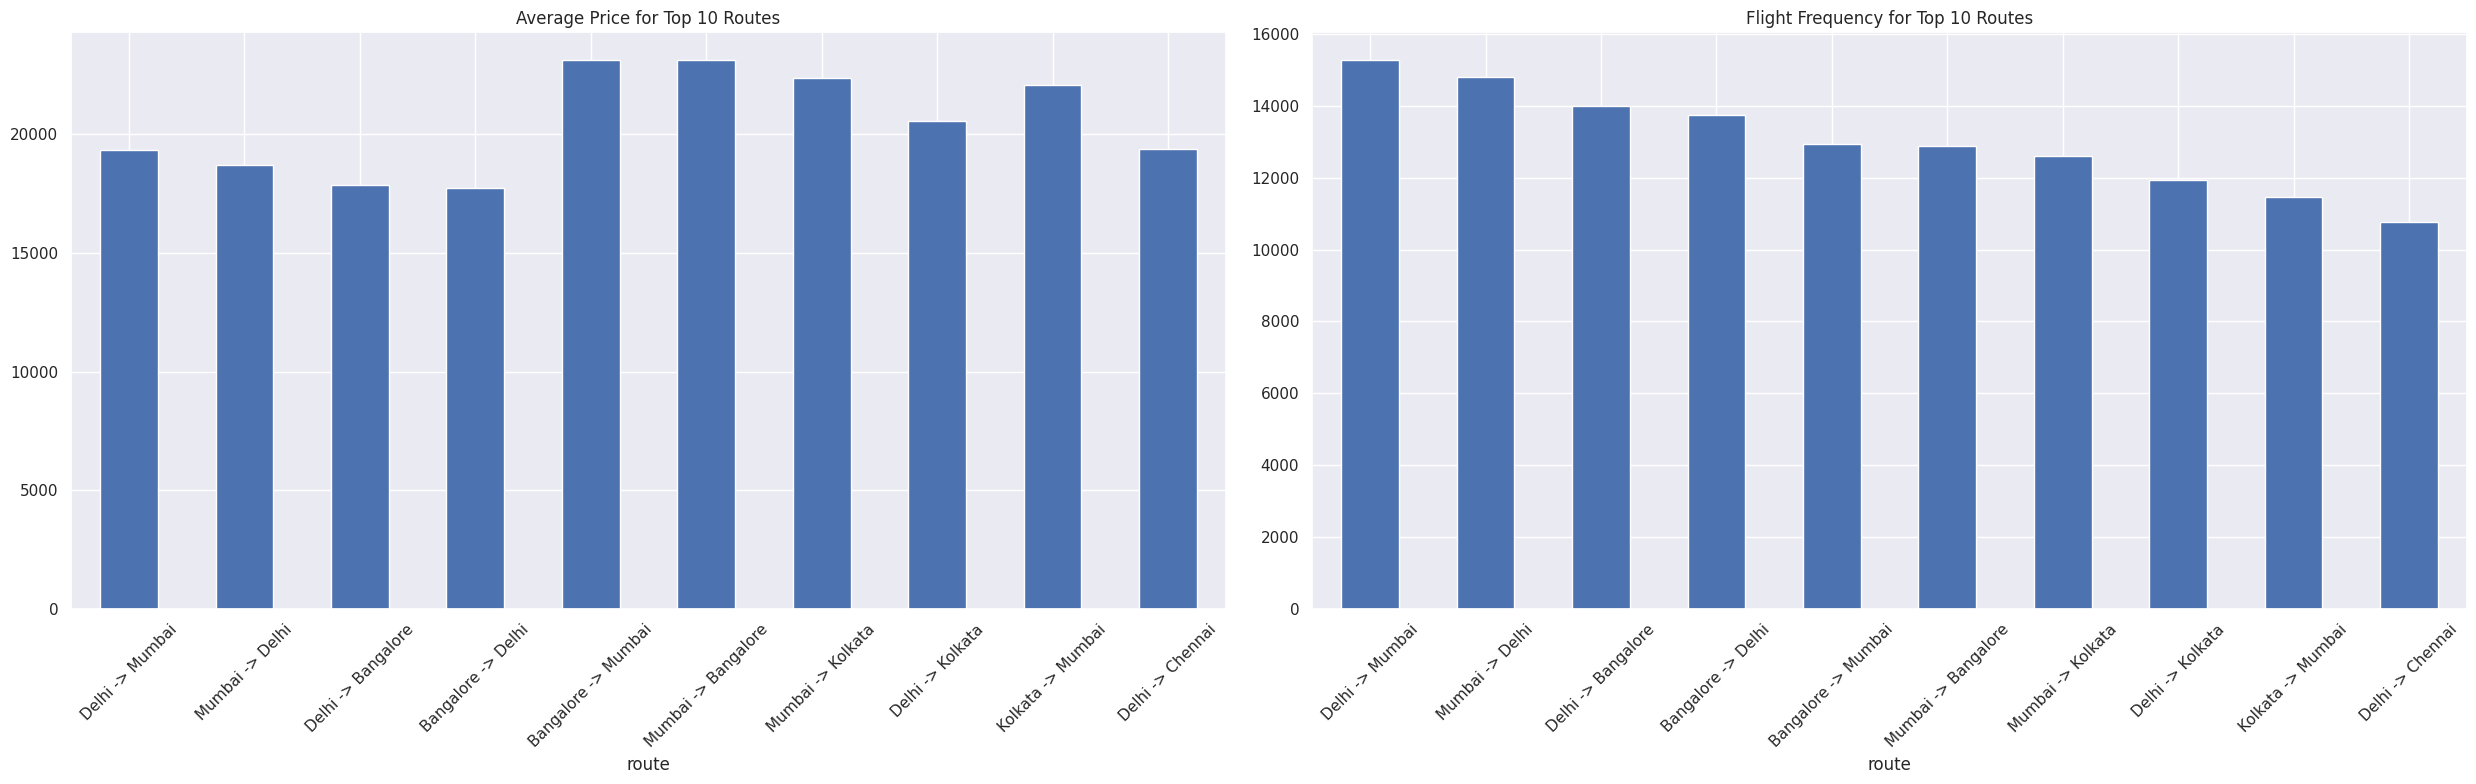

In [42]:
# Visualizing top routes
top_routes = route_analysis.head(10)
sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 2, figsize=(25, 8))
top_routes['avg_price'].plot(kind='bar', ax=axes[0])
axes[0].set_title('Average Price for Top 10 Routes')
axes[0].tick_params(axis='x', rotation=45)
top_routes['frequency'].plot(kind='bar', ax=axes[1])
axes[1].set_title('Flight Frequency for Top 10 Routes')
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

##### Observations:

1. Delhi-Mumbai and Mumbai-Delhi are busiest, averaging 18,700 to 19,300 despite heavy demand. Bangalore-Mumbai and Mumbai-Bangalore are priciest at 23,100+, likely due to business travel or limited competition.
2. Kolkata routes like Mumbai-Kolkata and Delhi-Kolkata cost 20,500 to 22,300, higher than Delhi-Chennai at 19,300 even with similar distances.
3. Longer flights, such as Mumbai-Kolkata at 12.99 hours, tend to cost more. Delhi-Chennai at 12.43 hours and 19,300 shows competition can lower prices.


**5. Analyzing Price by Departure and Arrival Times**

In [43]:
# Statistical summary by time slots
departure_stats = flight.groupby("departure_time")["price"].agg(['mean', 'std', 'count']).round(2)
arrival_stats = flight.groupby("arrival_time")["price"].agg(['mean', 'std', 'count']).round(2)
print("Price statistics by Departure Time:")
print(departure_stats)
print("\nPrice statistics by Arrival Time:")
print(arrival_stats)

Price statistics by Departure Time:
                     mean        std  count
departure_time                             
Afternoon      18179.2000 20928.8400  47794
Early_Morning  20370.6800 22354.8800  66790
Evening        21232.3600 23168.5200  65102
Late_Night      9295.3000 13680.5200   1306
Morning        21630.7600 22968.9100  71146
Night          23062.1500 23617.8800  48015

Price statistics by Arrival Time:
                    mean        std  count
arrival_time                              
Afternoon     18494.6000 20430.0100  38139
Early_Morning 14993.1400 18898.6900  15417
Evening       23044.3700 23494.6400  78323
Late_Night    11284.9100 16399.1200  14001
Morning       22231.0800 23266.0800  62735
Night         21586.7600 23298.0100  91538


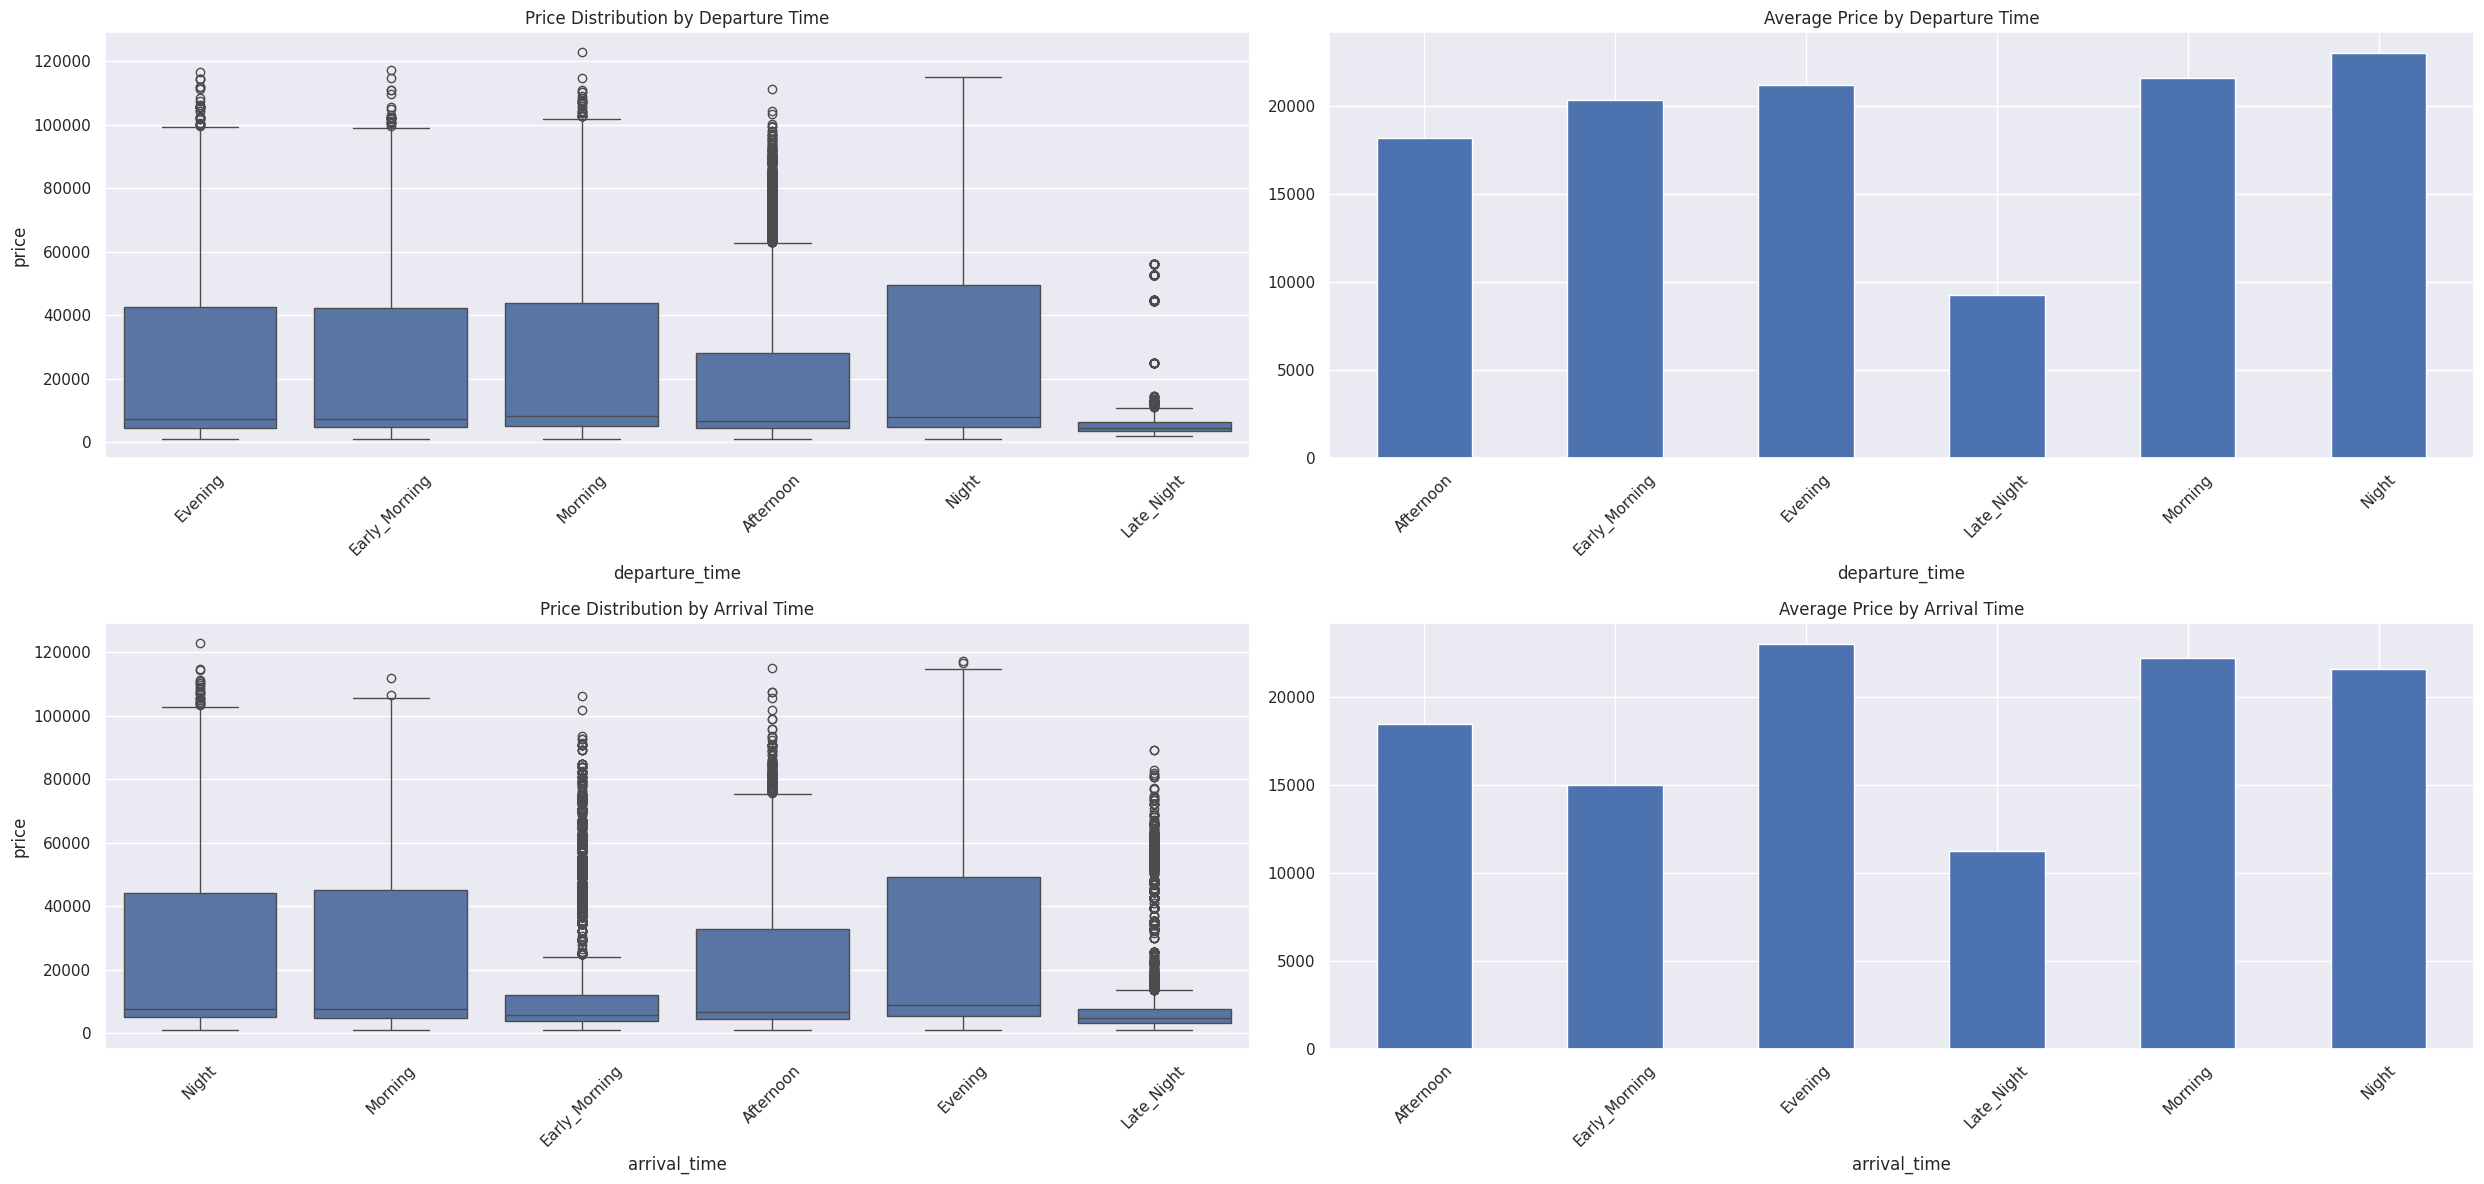

In [44]:
# Price by departure time
sns.set(style="darkgrid")
fig, axes = plt.subplots(2, 2, figsize=(25, 12))
sns.boxplot(x="departure_time", y="price", data=flight, ax=axes[0,0])
axes[0,0].set_title('Price Distribution by Departure Time')
axes[0,0].tick_params(axis='x', rotation=45)
flight.groupby("departure_time")["price"].mean().plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Average Price by Departure Time')
axes[0,1].tick_params(axis='x', rotation=45)
sns.boxplot(x="arrival_time", y="price", data=flight, ax=axes[1,0])
axes[1,0].set_title('Price Distribution by Arrival Time')
axes[1,0].tick_params(axis='x', rotation=45)
flight.groupby("arrival_time")["price"].mean().plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Average Price by Arrival Time')
axes[1,1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

##### Observations:

1.  Morning and night departures average 21,600 to 23,000 driven by business traveler demand. Late-night departures drop to about 9,300 but are rare with only 1,306 flights. Early morning departures average 20,370 showing moderate pricing.
2.  Evening arrivals are the most expensive at 23,044 while early morning arrivals are cheapest at 14,993. Night arrivals are common with 91,538 flights and average 21,586, offering a middle ground.
3. Morning departures cost much more than early morning arrivals presenting a savings opportunity. Late-night travel is cheapest on both ends but has very limited availability. Evening travel times remain consistently premium.


**6. Correlation Analysis**

In [45]:
# Create a copy for correlation analysis
flight_corr = flight.copy()

In [46]:
# Encode categorical variables for correlation analysis

label_encoders = {}
categorical_columns = ['airline', 'source_city', 'destination_city', 'departure_time', 'arrival_time', 'stops', 'class']

for col in categorical_columns:
    le = LabelEncoder()
    flight_corr[col + '_encoded'] = le.fit_transform(flight_corr[col])
    label_encoders[col] = le

In [47]:
# Select numerical and encoded columns for correlation
correlation_columns = ['price', 'duration'] + [col + '_encoded' for col in categorical_columns]
correlation_data = flight_corr[correlation_columns]

In [48]:
# Print correlation with price
correlation_matrix = correlation_data.corr()
price_correlations = correlation_matrix['price'].sort_values(key=abs, ascending=False)
print("Feature correlations with Price:")
print(price_correlations)

Feature correlations with Price:
price                       1.0000
class_encoded              -0.9379
airline_encoded             0.2434
duration                    0.2042
stops_encoded              -0.2026
departure_time_encoded      0.0583
arrival_time_encoded        0.0420
destination_city_encoded    0.0048
source_city_encoded         0.0046
Name: price, dtype: float64


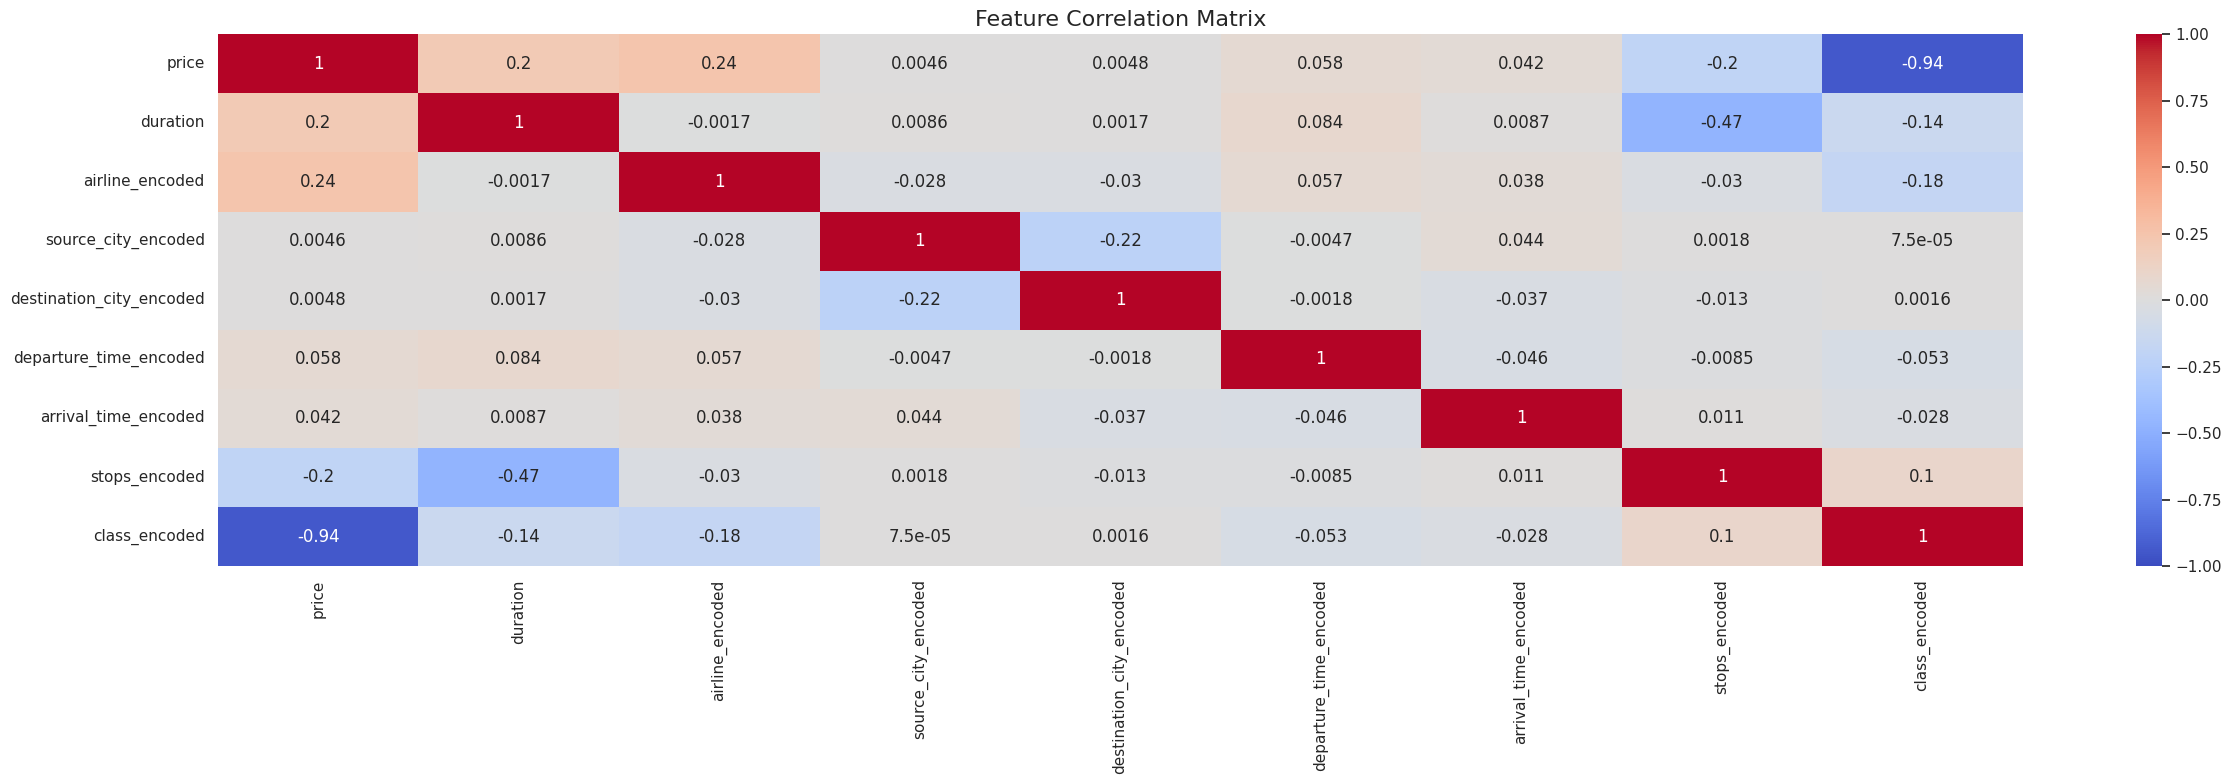

In [49]:
# Visualizing the correlation matrix
plt.figure(figsize=(25, 8))
sns.heatmap(correlation_matrix, vmin=-1, vmax=1, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix', fontsize=16)
plt.tight_layout()
plt.show()

##### Observations:
1. Class type has the strongest impact on price with a correlation of -0.94. Economy is much cheaper than business. Airline choice follows with 0.24 showing premium carriers charge more. Flight duration has a smaller effect at 0.20.
2. Source and destination cities have near-zero correlation with price meaning distance is not a major driver. Departure and arrival times also show weak links, suggesting complex dynamic pricing.
3. Number of stops reduces fares (-0.20). Multi-stop flights take longer, shown by the -0.47 correlation with duration.
4. Price predictions should focus on class, airline and stops. Timing and cities are minor factors. Airlines rely more on operational choices than obvious variables like distance or departure time.


### **3.3 Feature Engineering**

#### **3.3.1 Feature Encoding and Transformation**

Converting categorical variables to numerical format suitable for machine learning algorithms.

In [50]:
# Create a copy of the dataframe for feature engineering
flight_processed = flight.copy()

In [51]:
# Encoding categorical variables
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    flight_processed[col + '_encoded'] = le.fit_transform(flight_processed[col])
    label_encoders[col] = le
    print(f"Encoded {col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

Encoded airline: {'AirAsia': np.int64(0), 'Air_India': np.int64(1), 'GO_FIRST': np.int64(2), 'Indigo': np.int64(3), 'SpiceJet': np.int64(4), 'Vistara': np.int64(5)}
Encoded source_city: {'Bangalore': np.int64(0), 'Chennai': np.int64(1), 'Delhi': np.int64(2), 'Hyderabad': np.int64(3), 'Kolkata': np.int64(4), 'Mumbai': np.int64(5)}
Encoded destination_city: {'Bangalore': np.int64(0), 'Chennai': np.int64(1), 'Delhi': np.int64(2), 'Hyderabad': np.int64(3), 'Kolkata': np.int64(4), 'Mumbai': np.int64(5)}
Encoded departure_time: {'Afternoon': np.int64(0), 'Early_Morning': np.int64(1), 'Evening': np.int64(2), 'Late_Night': np.int64(3), 'Morning': np.int64(4), 'Night': np.int64(5)}
Encoded arrival_time: {'Afternoon': np.int64(0), 'Early_Morning': np.int64(1), 'Evening': np.int64(2), 'Late_Night': np.int64(3), 'Morning': np.int64(4), 'Night': np.int64(5)}
Encoded stops: {'one': np.int64(0), 'two_or_more': np.int64(1), 'zero': np.int64(2)}
Encoded class: {'Business': np.int64(0), 'Economy': np.in

In [52]:
# Drop original categorical columns and route column
flight_processed.drop(categorical_columns + ['route'], axis=1, inplace=True)

In [53]:
# Rename encoded columns
rename_dict = {col + '_encoded': col for col in categorical_columns}
flight_processed.rename(columns=rename_dict, inplace=True)

In [54]:
print("\nProcessed dataset shape:", flight_processed.shape)
print("Processed dataset columns:", flight_processed.columns.tolist())
flight_processed.head()


Processed dataset shape: (300153, 11)
Processed dataset columns: ['flight', 'duration', 'days_left', 'price', 'airline', 'source_city', 'destination_city', 'departure_time', 'arrival_time', 'stops', 'class']


,flight,duration,days_left,price,airline,source_city,destination_city,departure_time,arrival_time,stops,class
0,SG-8709,2.1700,1,5953,4,2,5,2,5,2,1
1,SG-8157,2.3300,1,5953,4,2,5,1,4,2,1
2,I5-764,2.1700,1,5956,0,2,5,1,1,2,1
3,UK-995,2.2500,1,5955,5,2,5,4,0,2,1
4,UK-963,2.3300,1,5955,5,2,5,4,4,2,1


## **4. Model Building**

We can now proceed to apply various regression algorithms to predict flight prices.

In [55]:
# Since flight column does not give any value now, we should drop it
flight_processed.drop('flight', axis=1, inplace=True)
print("Remaining data for modelling:", flight_processed.columns)

Remaining data for modelling: Index(['duration', 'days_left', 'price', 'airline', 'source_city',
       'destination_city', 'departure_time', 'arrival_time', 'stops', 'class'],
      dtype='object')


In [56]:
# Prepare features and target variable
X = flight_processed.drop('price', axis=1)
y = flight_processed['price']

In [57]:
print("Features shape:", X.shape)
print("Target shape:", y.shape)
print("Features:", X.columns.tolist())

Features shape: (300153, 9)
Target shape: (300153,)
Features: ['duration', 'days_left', 'airline', 'source_city', 'destination_city', 'departure_time', 'arrival_time', 'stops', 'class']


In [58]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=None)
print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")


Training set size: 240122
Testing set size: 60031


In [59]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### **4.2 Model Training and Evaluation**

Training multiple regression models and comparing their performance.

In [60]:
# Initialize multiple models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, objective='reg:squarederror'),
    'LightGBM': LGBMRegressor(n_estimators=100, random_state=42, verbosity=-1)
}

In [61]:
# Train and evaluate models
model_results = {}
trained_models = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Train the model
    if name == 'Linear Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    model_results[name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2_Score': r2
    }

    trained_models[name] = model

    print(f"{name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.4f}")


Training Linear Regression...
Linear Regression - MAE: 4624.99, RMSE: 7014.31, R2: 0.9046

Training Random Forest...
Random Forest - MAE: 1091.47, RMSE: 2786.47, R2: 0.9849

Training Gradient Boosting...
Gradient Boosting - MAE: 2959.68, RMSE: 4995.05, R2: 0.9516

Training XGBoost...
XGBoost - MAE: 2035.56, RMSE: 3560.69, R2: 0.9754

Training LightGBM...
LightGBM - MAE: 2371.13, RMSE: 4011.90, R2: 0.9688


In [62]:
# Display results in a formatted table
results_flight = pd.DataFrame(model_results).T
print(results_flight.round(4))

                        MAE           MSE      RMSE  R2_Score
Linear Regression 4624.9949 49200540.2937 7014.3097    0.9046
Random Forest     1091.4688  7764407.3834 2786.4686    0.9849
Gradient Boosting 2959.6750 24950509.1174 4995.0485    0.9516
XGBoost           2035.5624 12678545.0000 3560.6945    0.9754
LightGBM          2371.1286 16095328.5671 4011.8984    0.9688


##### Observations:
1. Random Forest leads with R² 0.985 and MAE 1,091 capturing complex feature interactions best.
2. XGBoost and LightGBM score R² above 0.96 but have 2–3x higher errors than Random Forest. Gradient Boosting is slightly weaker at R² 0.952.
3. Linear Regression lags with R² 0.905 and MAE 4,625 showing pricing is non-linear.
4. All models exceed R² 0.9, with RMSE between 2,786 and 7,014 making them useful for broad budget forecasts.


### **4.3 Model Performance Visualization**

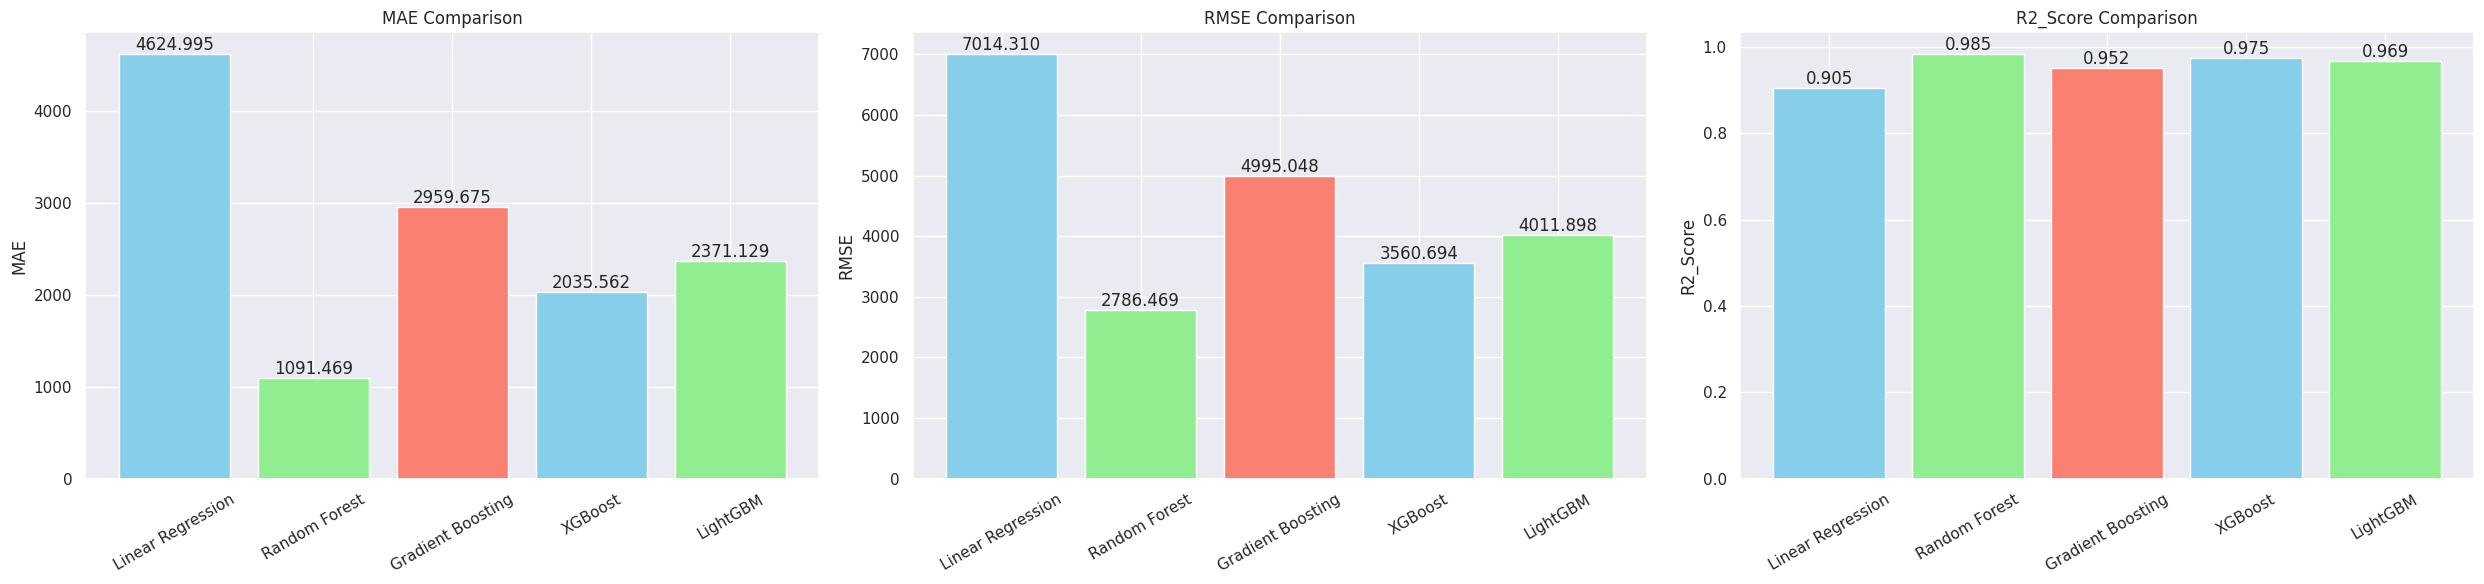

In [63]:
# Visualizing model performance
metrics = ['MAE', 'RMSE', 'R2_Score']
fig, axes = plt.subplots(1, 3, figsize=(25, 6))

for i, metric in enumerate(metrics):
    metric_values = [model_results[model][metric] for model in model_results.keys()]
    model_names = list(model_results.keys())

    bars = axes[i].bar(model_names, metric_values, color=['skyblue', 'lightgreen', 'salmon'])
    axes[i].set_title(f'{metric} Comparison')
    axes[i].set_ylabel(metric)
    axes[i].tick_params(axis='x', rotation=30)

    # Add value labels on bars
    for j, bar in enumerate(bars):
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

##### Observations:
1. MAE and RMSE show a perfect inverse relationship with R² indicating strong feature engineering.
2. Gradient Boosting underperforms XGBoost despite similar methods suggesting a need for hyperparameter tuning.


### **4.4 Best Model Analysis and Feature Importance**

In [64]:
# Identify the best model (highest R2 score)
best_model_name = max(model_results.keys(), key=lambda x: model_results[x]['R2_Score'])
best_model = trained_models[best_model_name]

print(f"Best performing model: {best_model_name},  with a score of: {model_results[best_model_name]['R2_Score']:.4f}")

Best performing model: Random Forest,  with a score of: 0.9849



Feature Importance (Random Forest):
            feature  importance
8             class      0.8799
0          duration      0.0597
1         days_left      0.0186
2           airline      0.0107
3       source_city      0.0107
4  destination_city      0.0095
6      arrival_time      0.0046
5    departure_time      0.0042
7             stops      0.0019


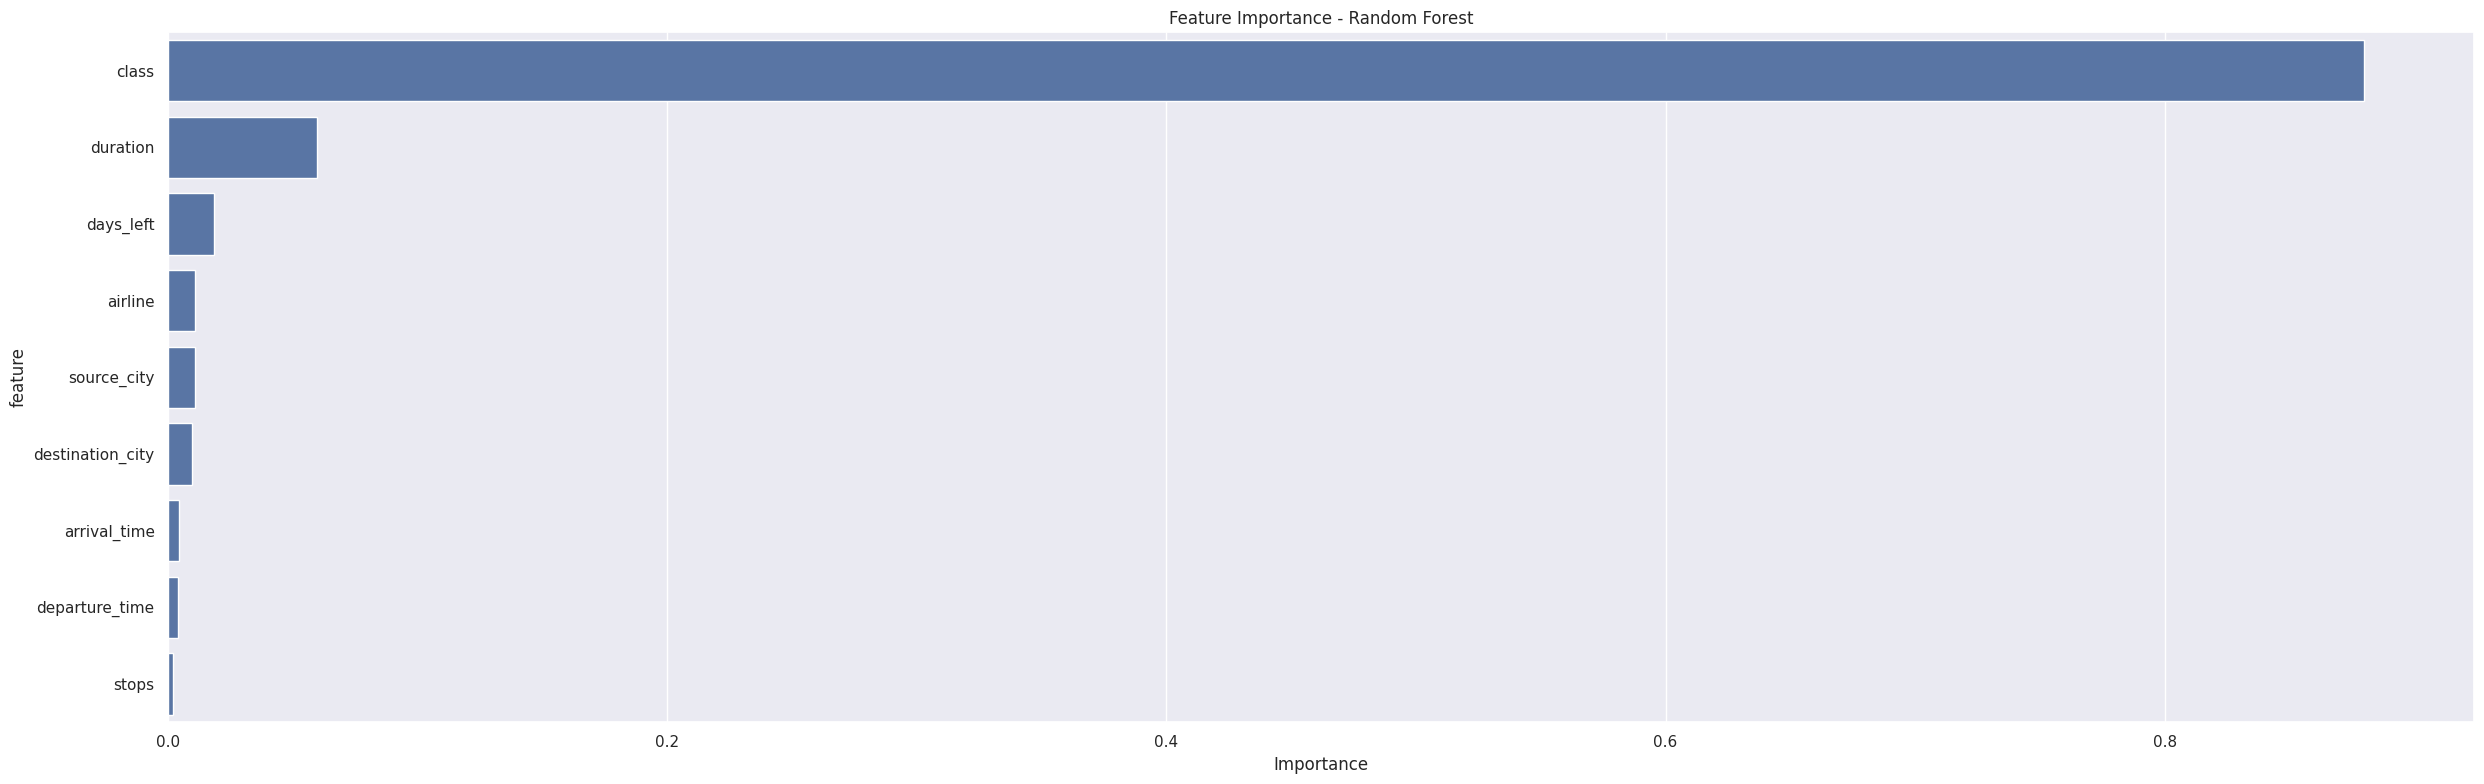

In [65]:
# Feature importance analysis (for tree-based models)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print(f"\nFeature Importance ({best_model_name}):")
    print(feature_importance)

    # Visualize feature importance
    plt.figure(figsize=(25, 8))
    sns.barplot(data=feature_importance, x='importance', y='feature')
    plt.title(f'Feature Importance - {best_model_name}')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

##### Observations:

Flight class dominates pricing, explaining 88% of fare variation, followed by duration at 5.97% and booking timing at 1.86%. 

Cities, timing and stops each contribute less than 1% indicating minimal standalone influence.


### **4.5 Hyperparameter Tuning**

Optimizing the best performing model using grid search.

In [66]:
# Hyperparameter tuning for the best model
if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [200, 300],
        'max_depth': [None, 10],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5],
        'learning_rate': [0.1, 0.2],
        'subsample': [0.9, 1.0]
    }
else:
    param_grid = {}

In [67]:
if param_grid:
    print(f"Performing hyperparameter tuning for {best_model_name}...")

    # Start timer
    start_time = time.time()

    # Create a new instance of the best model
    if best_model_name == 'Random Forest':
        base_model = RandomForestRegressor(random_state=42)
    elif best_model_name == 'Gradient Boosting':
        base_model = GradientBoostingRegressor(random_state=42)

    # Grid search with cross-validation
    grid_search = GridSearchCV(
        base_model,
        param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)

    print("Best parameters found:")
    print(grid_search.best_params_)
    print(f"Best cross-validation score: {-grid_search.best_score_:.4f}")

    # Evaluate the tuned model
    best_tuned_model = grid_search.best_estimator_
    y_pred_tuned = best_tuned_model.predict(X_test)

    tuned_metrics = {
        'MAE': mean_absolute_error(y_test, y_pred_tuned),
        'MSE': mean_squared_error(y_test, y_pred_tuned),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_tuned)),
        'R2_Score': r2_score(y_test, y_pred_tuned)
    }

    print(f"\nTuned {best_model_name} Performance:")
    for metric, value in tuned_metrics.items():
        print(f"{metric}: {value:.4f}")

    # Compare original vs tuned model
    comparison_flight = pd.DataFrame({
        'Original': list(model_results[best_model_name].values()),
        'Tuned': list(tuned_metrics.values())
    }, index=list(model_results[best_model_name].keys()))

    print(f"\nPerformance Comparison - {best_model_name}:")
    print(comparison_flight.round(4))

    # End timer and print elapsed time
    end_time = time.time()
    elapsed_time = (end_time - start_time) / 60
    print(f"\nTotal execution time: {elapsed_time:.2f} munites")

Performing hyperparameter tuning for Random Forest...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found:
{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Best cross-validation score: 7286458.1878

Tuned Random Forest Performance:
MAE: 1104.4775
MSE: 7249529.5470
RMSE: 2692.4950
R2_Score: 0.9859

Performance Comparison - Random Forest:
             Original        Tuned
MAE         1091.4688    1104.4775
MSE      7764407.3834 7249529.5470
RMSE        2786.4686    2692.4950
R2_Score       0.9849       0.9859

Total execution time: 147.21 munites


##### Observations:

1. The tuned model showed a slight but steady improvement with R² rising from 0.9849 to 0.9859 and RMSE dropping from ₹2,786 to ₹2,692. It used a complex tree structure with no max depth limit, moderate regularization and 300 trees. 

2. While MAE increased slightly from ₹1,091 to ₹1,104 the tuning reduced large errors by 3.5%. 

3. The 1.5-hour runtime raises questions about the value of tuning given the small gain on an already strong model.


### **4.6 Model Validation and Final Predictions**

In [68]:
# Final model selection
if 'best_tuned_model' in locals():
    final_model = best_tuned_model
    final_model_name = f"Tuned {best_model_name}"
else:
    final_model = best_model
    final_model_name = best_model_name

print(f"Final selected model: {final_model_name}")

Final selected model: Tuned Random Forest


In [69]:
# Make predictions on test set
y_final_pred = final_model.predict(X_test)

In [70]:
# Create prediction vs actual comparison
prediction_comparison = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_final_pred,
    'Absolute_Error': np.abs(y_test.values - y_final_pred)
}).head(20)

In [71]:
print("Predictions vs Actual Values:")
print(prediction_comparison.round(2))

Predictions vs Actual Values:
    Actual  Predicted  Absolute_Error
0     7366  6254.7200       1111.2800
1    64831 70044.1900       5213.1900
2     6195  6199.0300          4.0300
3    60160 61527.7200       1367.7200
4     6578  6526.5200         51.4800
5     4555  7283.5900       2728.5900
6    23838 23862.5800         24.5800
7     3860  3890.3200         30.3200
8    32230 49379.2000      17149.2000
9    76841 67642.0400       9198.9600
10   38099 38615.1200        516.1200
11   60508 60508.0000          0.0000
12    2477  2907.6400        430.6400
13    7220  5864.4600       1355.5400
14   32859 33221.8000        362.8000
15   20684 20658.9600         25.0400
16    7212  5545.4400       1666.5600
17    7762  5847.9000       1914.1000
18   22140 22618.1200        478.1200
19   10418 10784.6100        366.6100


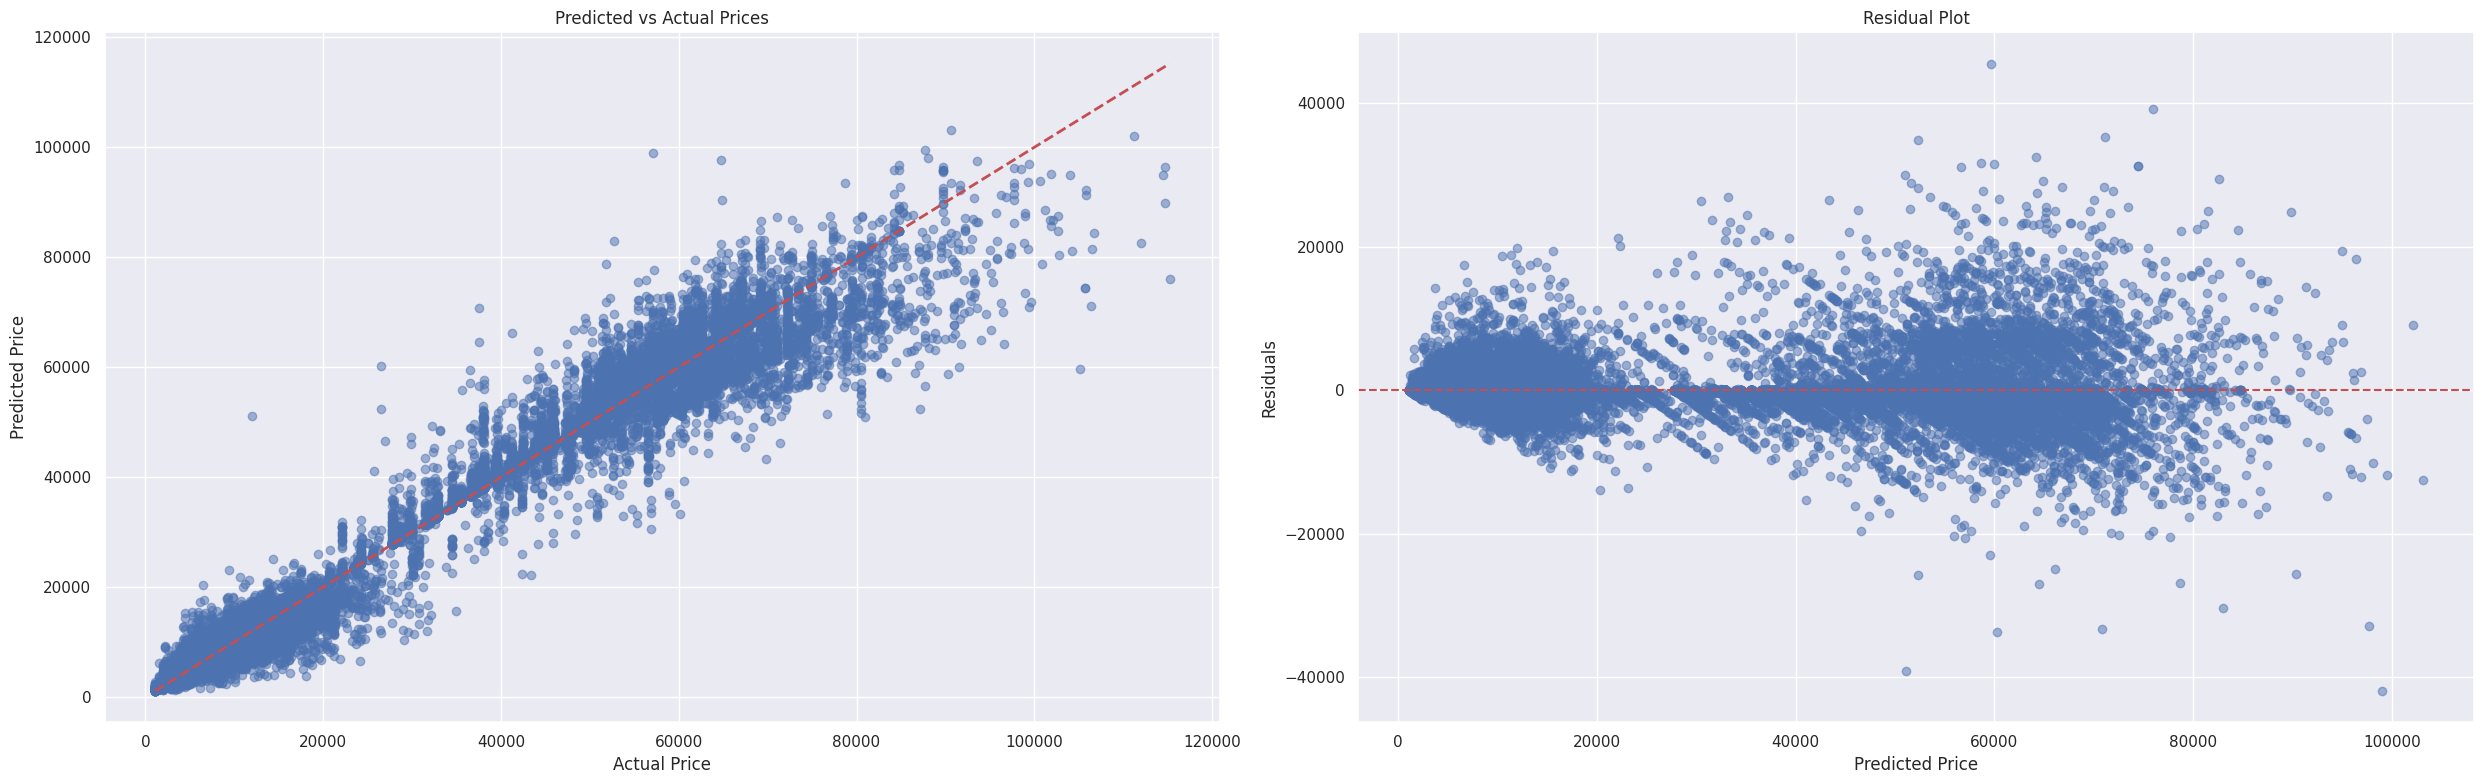

In [72]:
# Visualize predictions vs actual values
plt.figure(figsize=(25, 8))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_final_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Predicted vs Actual Prices');

plt.subplot(1, 2, 2)
residuals = y_test - y_final_pred
plt.scatter(y_final_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.tight_layout()
plt.show()

##### Observations
The model predicts mid-range fares (20,000 to 60,000) very accurately with points closely following the ideal line. 

In [73]:
# Calculate percentage accuracy
percentage_accuracy = []

for actual, predicted in zip(y_test.values, y_final_pred):
    if actual != 0:
        accuracy = (1 - abs(actual - predicted) / actual) * 100
        percentage_accuracy.append(max(0, accuracy))  # Ensure non-negative

In [74]:
avg_percentage_accuracy = np.mean(percentage_accuracy)
print(f"\nAverage Percentage Accuracy: {avg_percentage_accuracy:.2f}%")


Average Percentage Accuracy: 92.83%


##### Observations
The model predicts fares within an acceptable margin for 93% of cases showing reliable performance for most travelers.


### **4.7 Model Saving**

Saving the final model and preprocessing components for future use.

In [75]:
# Save the final model and scaler
model_filename = f'flight_price_prediction_model_{best_model_name.lower().replace(" ", "_")}.pkl'
scaler_filename = 'flight_price_scaler.pkl'
encoders_filename = 'flight_price_label_encoders.pkl'

In [76]:
# Save model
with open(model_filename, 'wb') as f:
    pickle.dump(final_model, f)
print(f"Model saved as: {model_filename}")

Model saved as: flight_price_prediction_model_random_forest.pkl


In [77]:
# Save scaler
with open(scaler_filename, 'wb') as f:
    pickle.dump(scaler, f)
print(f"Scaler saved as: {scaler_filename}")

Scaler saved as: flight_price_scaler.pkl


In [78]:
# Save label encoders
with open(encoders_filename, 'wb') as f:
    pickle.dump(label_encoders, f)
print(f"Label encoders saved as: {encoders_filename}")

Label encoders saved as: flight_price_label_encoders.pkl


In [79]:
# Create a summary of the final model
model_summary = {
    'Model Name': final_model_name,
    'Best Parameters': grid_search.best_params_ if 'grid_search' in locals() else 'Default',
    'Final Metrics': tuned_metrics if 'tuned_metrics' in locals() else model_results[best_model_name],
    'Average Percentage Accuracy': f"{avg_percentage_accuracy:.2f}%",
    'Training Data Size': X_train.shape[0],
    'Testing Data Size': X_test.shape[0],
    'Number of Features': X_train.shape[1]
}
for key, value in model_summary.items():
    print(f"{key}: {value}")

Model Name: Tuned Random Forest
Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Final Metrics: {'MAE': 1104.4774650092158, 'MSE': 7249529.54695379, 'RMSE': np.float64(2692.495041212479), 'R2_Score': 0.9859364134934018}
Average Percentage Accuracy: 92.83%
Training Data Size: 240122
Testing Data Size: 60031
Number of Features: 9


### **Conclusion**

Based on the analysis and model results we can derive several business insights.

Airline pricing varies widely, with Vistara as the most expensive at an average of ₹30,397 and AirAsia the cheapest at ₹4,091, a difference of ₹26,305. 

Business class averages ₹52,540 over 93,487 flights, while economy averages ₹6,572 across 206,666 flights. The busiest routes include Delhi-Mumbai and Mumbai-Delhi, with around 15,000 flights each and average prices near ₹19,000. 

Night departures cost the most at ₹23,062, while late-night flights are cheapest at ₹9,295. Flights with one stop average ₹22,901, making them costlier than direct flights at ₹9,376 and those with two or more stops at ₹14,113.

Let create an app

In [ ]:
# from google.colab import files
# files.download('flight_price_prediction_model_random_forest.pkl')
# files.download('flight_price_scaler.pkl')
# files.download('flight_price_label_encoders.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>